# Expressive Guitar Technique classifier
Ph.D. research project of [Domenico Stefani](work.domenicostefani.com)  
This notebook loads a dataset of feature vectors extracted from **pitched** and **percussive** sounds recorded with many acoustic guitars.
The techniques/classes recorded are:  

0.    **Kick**      (Palm on lower body)
1.    **Snare 1**   (All fingers on lower side)
2.    **Tom**       (Thumb on higher body)
3.    **Snare 2**   (Fingers on the muted strings, over the end
of the fingerboard)
___
4.    **Natural Harmonics** (Stop strings from playing the dominant frequency, letting harmonics ring)
5.    **Palm Mute** (Muting partially the strings with the palm
of the pick hand)
6.    **Pick Near Bridge** (Playing toward the bridge/saddle)
7.    **Pick Over the Soundhole** (Playing over the sound hole)


In [1]:
TRAIN_ONLY_ON_FULL_DATASET = False

## Import modules and mount drive folder

In [2]:
# Choose ClassificationTask task
from enum import Enum
class ClassificationTask(Enum):
    FULL_8_CLASS_PROBLEM,BINARY_PERCUSSIVE_PITCHED,PERCUSSIVE_4_ONLY,PITCHED_4_ONLY,PERCUSSIVE_PLUS_PITCHED_CLASS,ONE_GUITARIST_FULL = ((1,'full'), (2,'binary'), (3,'perc'), (4,'pitch'), (5,'perc+pitch'), (6,'one-guit-full'))
class FeatureSelection(Enum):
    NONE,MANUAL_VARIABLES,MANUAL_LIST,AUTO_ANOVA,AUTO_RELIEF = (0, 1, 2, 3, 4)
class FeatureWindowSize(Enum):
    s4800_SAMPLES_100ms, s704_Samples_14ms, _704windowed, _2112windowed, _3456windowed, _4800windowed = (1,2,3,4,5,6)

class WindowedInputMode(Enum):
    _1D, _2D = (1, 2)

In [3]:
classification_task = ClassificationTask.FULL_8_CLASS_PROBLEM
# classification_task = ClassificationTask.BINARY_PERCUSSIVE_PITCHED
# classification_task = ClassificationTask.PERCUSSIVE_4_ONLY
# classification_task = ClassificationTask.PERCUSSIVE_PLUS_PITCHED_CLASS
# classification_task = ClassificationTask.ONE_GUITARIST_FULL

# FEATURE_SELECTION = FeatureSelection.MANUAL_VARIABLES
# FEATURE_SELECTION = FeatureSelection.MANUAL_LIST
FEATURE_SELECTION = FeatureSelection.AUTO_ANOVA #ANOVA: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html
# FEATURE_SELECTION = FeatureSelection.AUTO_RELIEF

# FEATURE_WINDOW_SIZE = FeatureWindowSize.s4800_SAMPLES_100ms
# FEATURE_WINDOW_SIZE = FeatureWindowSize.s704_Samples_14ms
# FEATURE_WINDOW_SIZE = FeatureWindowSize._704windowed
# FEATURE_WINDOW_SIZE = FeatureWindowSize._2112windowed
# FEATURE_WINDOW_SIZE = FeatureWindowSize._3456windowed
FEATURE_WINDOW_SIZE = FeatureWindowSize._4800windowed

# WINDOWED_INPUT_MODE = WindowedInputMode._1D
WINDOWED_INPUT_MODE = WindowedInputMode._2D

# WindowedInputMode._2D implies that 'windowed' is in FEATURE_WINDOW_SIZE.name
assert (not (WINDOWED_INPUT_MODE == WindowedInputMode._2D)) or ('windowed' in FEATURE_WINDOW_SIZE.name), "WindowedInputMode._2D implies that 'windowed' is in FEATURE_WINDOW_SIZE.name"


# DROP_ADDITIONAL_CEPSTRUM_FROM_BIG_WINDOW = True

# SCALER_TO_USE = 'StandardScaler'
SCALER_TO_USE = 'MinMaxScaler'

#import sklearn scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
if SCALER_TO_USE == 'StandardScaler':
    SCALER_TO_USE = StandardScaler()
elif SCALER_TO_USE == 'MinMaxScaler':
    SCALER_TO_USE = MinMaxScaler()

TRAIN_FINAL_MODEL = False

In [4]:
# Install module for the ReliefF feature selection
# !pip install skrebate
# !pip install tensorboard
# !pip3 install pickle5
# !pip3 install tensorflow==2.4.1
# !pip3 install tensorboard

In [5]:
REQUIRE_GPU = False
DO_SAVE_TENSORBOARD_LOGS = False 
DO_SAVE_FOLD_MODELS = False 
CUSTOM_PLAYER_K_FOLD = True         # Very important, this ditches the k-fold stratified random shuffle, and creates as many splits as the guitar players, separating natural groups
DROP_EXTRA_PERCUSSIVE_SOUNDS = True # If true, drop the data from files that have 'extra' in the filename, which otherwise make the dataset unbalanced
# --> Quantize (Dynamic) and test the TF Lite model obtained (quicker but lower accuracy)
DO_TEST_QUANTIZATION = True

USE_TENSORBOARD = True

if FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
    USE_AUGMENTED_DATA = True
elif FEATURE_WINDOW_SIZE == FeatureWindowSize.s4800_SAMPLES_100ms:
    USE_AUGMENTED_DATA = False
    
elif FEATURE_WINDOW_SIZE == FeatureWindowSize._704windowed:
    USE_AUGMENTED_DATA = False
elif FEATURE_WINDOW_SIZE == FeatureWindowSize._2112windowed:
    USE_AUGMENTED_DATA = False
elif FEATURE_WINDOW_SIZE == FeatureWindowSize._3456windowed:
    USE_AUGMENTED_DATA = False
elif FEATURE_WINDOW_SIZE == FeatureWindowSize._4800windowed:
    USE_AUGMENTED_DATA = False
else:
    raise ValueError('Invalid feature window size')
# USE_AUGMENTED_DATA = False
DROP_EXTRA_PERCUSSIVE_SOUNDS_FROMAUG = False

DO_NORMALIZE_DATA = True

DO_NORMALIZE_FOR_FEATURE_SELECTION = True

# Load the TensorBoard notebook extension
if USE_TENSORBOARD:
    %load_ext tensorboard

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from sys import executable as sys_executable
from sys import argv as sys_argv
import pandas as pd
import numpy as np
import tensorflow as tf
from time import strftime, time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from bz2 import BZ2File # To open compressed data
import re
import shutil
import imblearn
from sklearn.metrics import confusion_matrix as sk_conf_matrix
from sklearn.metrics import classification_report as sk_class_report
from sklearn.metrics import ConfusionMatrixDisplay as sk_conf_matrix_disp

print("Tensorflow version: " + tf.version.VERSION)
print('Imblearn version:',imblearn.__version__)

global_random_state = 43

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(global_random_state)

COLAB = 'google.colab' in str(get_ipython())

if COLAB:
    print('Running on CoLab')
    #Connect and mount the drive folder that contains the train dataset and the output folder
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=False)

    HOMEBASE = os.path.join('/content','gdrive','MyDrive','dottorato','Publications','02-IEEE-RTEmbeddedTimbreClassification(submitted)','Classifier')
    THISDIR = "/content/"
else:
    print('Not running on CoLab')
    HOMEBASE = "."
    THISDIR = "./"
DATAFOLDER = os.path.join(HOMEBASE,"data/phase3")
MODELFOLDER = os.path.join(HOMEBASE,"output")

RELIEF_CACHE_FILEPATH = os.path.join(DATAFOLDER,'relief_cache.pickle')


Tensorflow version: 2.4.1
Imblearn version: 0.6.2
Not running on CoLab


In [6]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

## Enforce GPU usage

In [7]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
physical_devices = tf.config.list_physical_devices('GPU') 

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

print(physical_devices)
if REQUIRE_GPU:
  assert len(tf.config.experimental.list_physical_devices('GPU')) >= 1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Check Real avaliable GRAM

In [8]:
import subprocess
import sys

def pip_install(package):
    subprocess.check_call([executable, "-m", "pip", "install", package])

In [9]:
CHECK_GRAM = False

if CHECK_GRAM:
    # memory footprint support libraries/code
    os.symlink('/opt/bin/nvidia-smi','/usr/bin/nvidia-smi')
    pip_install('gputil')
    pip_install('psutil')
    pip_install('humanize')
    import psutil
    import humanize
    import os
    import GPUtil as GPU
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[0]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm()

# Import Dataset

In [10]:
if FEATURE_WINDOW_SIZE == FeatureWindowSize.s4800_SAMPLES_100ms:
    DATASET_FILENAME = 'onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221206-165551_SUPERLONGdataset-phase3PROCESSED_FEATURES.pickle'
elif FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
    DATASET_FILENAME = 'onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20221201-182312_REALTIMEdataset-phase3PROCESSED_FEATURES.pickle'
elif FEATURE_WINDOW_SIZE == FeatureWindowSize._704windowed:
    DATASET_FILENAME = 'paper-onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20230119-141803_windowed704-mainset-phase3PROCESSED_FEATURES.pickle'
elif FEATURE_WINDOW_SIZE == FeatureWindowSize._2112windowed:
    DATASET_FILENAME = 'paper-onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20230119-163834_windowed2112-mainset-phase3PROCESSED_FEATURES.pickle'
elif FEATURE_WINDOW_SIZE == FeatureWindowSize._3456windowed:
    DATASET_FILENAME = 'paper-onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20230120-081628_windowed3456-mainset-phase3PROCESSED_FEATURES.pickle'
elif FEATURE_WINDOW_SIZE == FeatureWindowSize._4800windowed:
    DATASET_FILENAME = 'paper-onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20230119-105343_windowed4800-mainset-phase3PROCESSED_FEATURES.pickle'
else:
    raise ValueError('Invalid FeatureWindowSize "%s"'%FeatureWindowSize.name)

print('Loading dataset from file:',DATASET_FILENAME)


if os.path.splitext(DATASET_FILENAME)[1] == '.bz2':
    print("Reading dataset from compressed pickle...")
    DATASET_PATH = os.path.join(DATAFOLDER,DATASET_FILENAME)
    startime = time()
    ifile = BZ2File(DATASET_PATH,'rb')
    featuredataset = pickle.load(ifile)
    ifile.close()
    print('Successfully Loaded!\nIt took %.1fs to load from compressed pickle' % (time()-startime))
elif os.path.splitext(DATASET_FILENAME)[1] == '.pickle':
    print("Reading dataset from pickle...")
    DATASET_PATH = os.path.join(DATAFOLDER,DATASET_FILENAME)
    startime = time()
    with open(DATASET_PATH,'rb') as pf:
        featuredataset = pickle.load(pf)
    print('Successfully Loaded!\nIt took %.1fs to load from regular pickle' % (time()-startime))
else:
    raise Exception("Extension %s not supported!" % os.path.splitext(DATASET_FILENAME)[1])
print('Dataset loaded!')
# display(featuredataset)
DATA_IS_WINDOWED = featuredataset.columns.str.match('0_').any()
WINDOW_INDEXES = sorted(list(set([int(e.split('_')[0]) for e in featuredataset.columns[featuredataset.columns.str.match('\d+_')].to_list()])))
print('Data is WINDOWED!' if DATA_IS_WINDOWED else '', '%d windows' % (len(WINDOW_INDEXES)))

Loading dataset from file: paper-onlycorrectdetections_extraction-outputPROCESSED_FEATURES_20230119-105343_windowed4800-mainset-phase3PROCESSED_FEATURES.pickle
Reading dataset from pickle...
Successfully Loaded!
It took 20.5s to load from regular pickle
Dataset loaded!
Data is WINDOWED! 38 windows


In [11]:
from glob import glob
augmented_featuredataset_list = []
if USE_AUGMENTED_DATA:
    augmented_data_paths = glob(os.path.join(DATAFOLDER,'augmented_data','*.pickle'))
    for augmented_data_path in augmented_data_paths:
        print("Loading file %s" % os.path.basename(augmented_data_path))
        with open(augmented_data_path,'rb') as pf:
            augmented_featuredataset_list.append(pickle.load(pf))
    augmented_featuredataset = pd.concat(augmented_featuredataset_list, ignore_index=True)
    print("Loaded %d augmented samples" % len(augmented_featuredataset))

### Drop features that we have found to be problematic with feature selection and training

In [12]:
def drop_unused_features_old(features_df: pd.DataFrame, is_windowed = False, inplace = False) -> pd.DataFrame:
    if not inplace:
        res_df = features_df.copy()
        print('Copied',flush=True)
    else:
        res_df = features_df
        print('Not Copied',flush=True)


    if is_windowed:
        for window_index in WINDOW_INDEXES:
            print('Dropping bad columns for index %d'%(window_index),flush=True)

            if '%s_attackTime_peaksamp'%window_index       not in res_df.columns.to_list() or\
               '%s_attackTime_attackStartIdx'%window_index not in res_df.columns.to_list() or\
               '%s_peakSample_index'%window_index          not in res_df.columns.to_list():
                # raise Exception("The features dataframe does not contain the required columns!")
                # Show warning instead of exception
                print("Warning! The features dataframe does not contain the required columns! (%s, %s, %s)"%('%s_attackTime_peaksamp'%window_index,'%s_attackTime_attackStartIdx'%window_index,'%s_peakSample_index'%window_index))
            else:
                res_df.drop(columns=['%s_attackTime_peaksamp' % window_index,\
                                        '%s_attackTime_attackStartIdx' % window_index,\
                                        '%s_peakSample_index' % window_index], inplace=True)
    else:
        if 'attackTime_peaksamp'       not in res_df.columns.to_list() or\
        'attackTime_attackStartIdx' not in res_df.columns.to_list() or\
        'peakSample_index'          not in res_df.columns.to_list():
            # raise Exception("The features dataframe does not contain the required columns!")
            print("Warning! The features dataframe does not contain the required columns! (%s, %s, %s)" % ('attackTime_peaksamp' in res_df.columns.to_list(), 'attackTime_attackStartIdx' in res_df.columns.to_list(), 'peakSample_index' in res_df.columns.to_list()))
        else:
            res_df.drop(columns=['attackTime_peaksamp',\
                                    'attackTime_attackStartIdx',\
                                    'peakSample_index'], inplace=True)
    return res_df

def drop_unused_features(features_df: pd.DataFrame, is_windowed = False, inplace = False) -> pd.DataFrame:
    if not inplace:
        res_df = features_df.copy()
        print('Copied',flush=True)
    else:
        res_df = features_df
        print('Not Copied',flush=True)

    todrop = []
    if is_windowed:
        for window_index in WINDOW_INDEXES:
            if '%s_attackTime_peaksamp'%window_index not in res_df.columns.to_list() or '%s_attackTime_attackStartIdx'%window_index not in res_df.columns.to_list() or '%s_peakSample_index'%window_index not in res_df.columns.to_list():
                print("Warning! The features dataframe does not contain the required columns! (%s, %s, %s)"%('%s_attackTime_peaksamp'%window_index,'%s_attackTime_attackStartIdx'%window_index,'%s_peakSample_index'%window_index))
            else:
                todrop.extend(['%s_attackTime_peaksamp' % window_index,'%s_attackTime_attackStartIdx' % window_index,'%s_peakSample_index' % window_index])
    else:
        if 'attackTime_peaksamp' not in res_df.columns.to_list() or 'attackTime_attackStartIdx' not in res_df.columns.to_list() or 'peakSample_index' not in res_df.columns.to_list():
            print("Warning! The features dataframe does not contain the required columns! (%s, %s, %s)" % ('attackTime_peaksamp' in res_df.columns.to_list(), 'attackTime_attackStartIdx' in res_df.columns.to_list(), 'peakSample_index' in res_df.columns.to_list()))
        else:
            todrop.extend(['attackTime_peaksamp','attackTime_attackStartIdx','peakSample_index'])

    res_df.drop(columns=todrop, inplace=True)
    return res_df


#measure time
startime = time()
featuredataset = drop_unused_features(featuredataset, is_windowed = DATA_IS_WINDOWED)
print('It took %.1fs to drop unused features' % (time()-startime))
if USE_AUGMENTED_DATA:
    augmented_featuredataset = drop_unused_features(augmented_featuredataset, is_windowed = DATA_IS_WINDOWED)

Copied
It took 6.8s to drop unused features


In [13]:
# if DROP_ADDITIONAL_CEPSTRUM_FROM_BIG_WINDOW:

#     # Largest cepstrum now:
#     larg_ceps = max([int(e.split('_')[-1]) for e in featuredataset.columns.to_list() if 'cepstrum' in e])
#     # Max xepstrum coeff. of smallest window (704 samples)
#     smallest_ceps = 704//2+1

#     featuredataset.drop(columns=[f'cepstrum_{v}' for v in range(smallest_ceps+1,larg_ceps + 1)], inplace=True)

### If specified, drop extra percussive recorded data

In [14]:
# if FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
#     assert featuredataset.shape == (EXPECTED_DATASED_SIZE, 504)
if DROP_EXTRA_PERCUSSIVE_SOUNDS:
    to_drop_count = np.count_nonzero(featuredataset.meta_audiofilePath.str.contains("additional-500").values)
    if to_drop_count >= 0:
        print('Dropping %d additional percussive recordings because "DROP_EXTRA_PERCUSSIVE_SOUNDS" was specified.'%(to_drop_count))
        featuredataset = featuredataset[~featuredataset.meta_audiofilePath.str.contains("additional-500")].reset_index(drop=True)
        print('Dataset shape after dropping extra percussive recordings: %s'%(str(featuredataset.shape)))
    # if FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
    #     assert featuredataset.shape == (EXPECTED_DATASED_SIZE-2237, 504)


if USE_AUGMENTED_DATA and DROP_EXTRA_PERCUSSIVE_SOUNDS_FROMAUG:
    augmented_featuredataset_dr = augmented_featuredataset.copy()
    to_drop_count_aug = np.count_nonzero(augmented_featuredataset.meta_augmentation_source.str.contains("additional-500").values)
    if to_drop_count_aug >= 0:
        print('Dropping %d additional percussive recordings because "DROP_EXTRA_PERCUSSIVE_SOUNDS" was specified.'%(to_drop_count_aug))
        augmented_featuredataset_dr = augmented_featuredataset[~augmented_featuredataset.meta_augmentation_source.str.contains("additional-500")].reset_index(drop=True)
        print('Dataset shape after dropping extra percussive recordings: %s'%(str(augmented_featuredataset_dr.shape)))

Dropping 2234 additional percussive recordings because "DROP_EXTRA_PERCUSSIVE_SOUNDS" was specified.
Dataset shape after dropping extra percussive recordings: (20636, 10307)


In [15]:
# Extract separate DFs
from typing import Tuple

# Divide dataset into metadata, features and labels
def divide_dataset(features_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # print time of eacch operation / line
    # startime = time()
    metadata = features_df.filter(regex='^meta_',axis=1)
    # print('It took %.1fs to extract metadata' % (time()-startime))
    # startime = time()
    labels = features_df.meta_expressive_technique_id
    # print('It took %.1fs to extract labels' % (time()-startime))
    # startime = time()
    features = features_df.loc[:,[col for col in features_df.columns if col not in metadata.columns]]
    # print('It took %.1fs to extract features' % (time()-startime))
    # Convert to numeric formats where possible (somehow convert_dtypes doesn't work [https://stackoverflow.com/questions/65915048/pandas-convert-dtypes-not-working-on-numbers-marked-as-objects])
    # startime = time()
    metadata = metadata.apply(pd.to_numeric, errors='ignore')
    labels = labels.apply(pd.to_numeric, errors='ignore')
    features = features.apply(pd.to_numeric, errors='ignore')
    # print('It took %.1fs to convert to numeric types' % (time()-startime))
    return metadata, features, labels

metadata, features, labels = divide_dataset(featuredataset)
assert metadata.shape[1] == 9
if FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
    assert features.shape[1] == 495
elif FEATURE_WINDOW_SIZE == FeatureWindowSize.s4800_SAMPLES_100ms:
    assert features.shape[1] == 2543

if USE_AUGMENTED_DATA:
    metadata_aug, features_aug, labels_aug = divide_dataset(augmented_featuredataset_dr if DROP_EXTRA_PERCUSSIVE_SOUNDS_FROMAUG else augmented_featuredataset)

In [16]:
def get_classes_description(classftask: ClassificationTask):
    if classification_task == ClassificationTask.FULL_8_CLASS_PROBLEM:
        classes_desk = {0:"Kick",1:"Snare 1",2:"Tom",3:"Snare 2",4:"Natural Harmonics",5:"Palm Mute",6:"Pick Near Bridge",7:"Pick Over the Soundhole"}
        shortnames = {0:"Kick",1:"Snare1",2:"Tom",3:"Snare2",4:"NatHarm",5:"PalmMute",6:"BridgeP",7:"SoundholeP"}
    elif classification_task == ClassificationTask.BINARY_PERCUSSIVE_PITCHED:
        classes_desk = {0:"Percussive",1:"Pitched"}
        shortnames = {0:"Perc",1:"Pitch"}
    elif classification_task == ClassificationTask.PERCUSSIVE_4_ONLY:
        classes_desk = {0:"Kick", 1:"Snare 1", 2:"Tom", 3:"Snare 2"}
        shortnames = {0:"Kick",1:"Snare1",2:"Tom",3:"Snare2"}
    elif classification_task == ClassificationTask.PITCHED_4_ONLY:
        classes_desk = {0:"Natural Harmonics", 1:"Palm Mute", 2:"Pick Near Bridge", 3:"Pick Over the Soundhole"}
        shortnames = {0:"NatHarm",1:"PalmMute",2:"BridgeP",3:"SoundholeP"}
    elif classification_task == ClassificationTask.PERCUSSIVE_PLUS_PITCHED_CLASS:
        classes_desk = {0:"Kick", 1:"Snare 1", 2:"Tom", 3:"Snare 2", 4:"Pitched"}
        shortnames = {0:"Kick",1:"Snare1",2:"Tom",3:"Snare2",4:"NatHarm",5:"Pitch"}
    elif classification_task == ClassificationTask.ONE_GUITARIST_FULL:
        classes_desk = {0:"Kick",1:"Snare 1",2:"Tom",3:"Snare 2",4:"Natural Harmonics",5:"Palm Mute",6:"Pick Near Bridge",7:"Pick Over the Soundhole"}
        shortnames = {0:"Kick",1:"Snare1",2:"Tom",3:"Snare2",4:"NatHarm",5:"PalmMute",6:"BridgeP",7:"SoundholeP"}
    else:
        raise Exception('The Classification Task selected is not supported')
    classes = list(classes_desk.keys())
    return classes,classes_desk,shortnames

def filter_dataset(tofilt_features,tofilt_labels,tofilt_metadata,classftask: ClassificationTask, hardcoded_sizes_test = False):
    if classification_task == ClassificationTask.FULL_8_CLASS_PROBLEM:
        pass
    elif classification_task == ClassificationTask.BINARY_PERCUSSIVE_PITCHED:
        assert len(tofilt_features) == len(tofilt_labels)
        # if hardcoded_sizes_test:
        #     assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237
        tofilt_labels = tofilt_labels.replace([0,1,2,3],[0,0,0,0])
        tofilt_labels = tofilt_labels.replace([4,5,6,7],[1,1,1,1])
    elif classification_task == ClassificationTask.PERCUSSIVE_4_ONLY:
        assert len(tofilt_features) == len(tofilt_labels)
        # if hardcoded_sizes_test:
        #     assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237
        filtered_idxs = tofilt_labels < 4
        tofilt_features = tofilt_features[filtered_idxs]
        tofilt_labels = tofilt_labels[filtered_idxs]
        tofilt_metadata = tofilt_metadata[filtered_idxs].copy()
        assert len(tofilt_features) == len(tofilt_labels)
        if hardcoded_sizes_test:
            assert len(tofilt_features) == 1620
    elif classification_task == ClassificationTask.PITCHED_4_ONLY:
        assert len(tofilt_features) == len(tofilt_labels)
        # if hardcoded_sizes_test:
        #     assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237
        filtered_idxs = tofilt_labels >= 4
        tofilt_features = tofilt_features[filtered_idxs]
        tofilt_metadata = tofilt_metadata[filtered_idxs].copy()
        tofilt_labels = tofilt_labels[filtered_idxs]
        tofilt_labels = tofilt_labels.replace([4,5,6,7],[0,1,2,3])
        assert len(tofilt_features) == len(tofilt_labels)
        # if hardcoded_sizes_test:
        #     assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237-1620
    elif classification_task == ClassificationTask.PERCUSSIVE_PLUS_PITCHED_CLASS:
        assert len(tofilt_features) == len(tofilt_labels)
        # if hardcoded_sizes_test:
        #     assert len(tofilt_features) == EXPECTED_DATASED_SIZE-2237
        tofilt_labels = tofilt_labels.replace([5,6,7],[4,4,4])
    elif classification_task == ClassificationTask.ONE_GUITARIST_FULL:

        filtered_idxs = tofilt_features['']
        # tofilt_features = tofilt_features[filtered_idxs]
        # tofilt_labels = tofilt_labels[filtered_idxs]
        # tofilt_metadata = tofilt_metadata[filtered_idxs].copy()
        # assert len(tofilt_features) == len(tofilt_labels)
        # if hardcoded_sizes_test:
        #     assert len(tofilt_features) == 1620
    else:
        raise Exception('The Classification Task selected is not supported')


    tofilt_features.reset_index(drop=True,inplace=True)
    tofilt_labels.reset_index(drop=True,inplace=True)
    tofilt_metadata.reset_index(drop=True,inplace=True)

    return tofilt_features, tofilt_labels, tofilt_metadata

original_dataset_features = features.copy()
dataset_labels = labels.copy()
dataset_metadata = metadata.copy()

CLASSES,CLASSES_DESC,SHORTDESC = get_classes_description(classification_task)
original_dataset_features,dataset_labels,dataset_metadata = filter_dataset(original_dataset_features,dataset_labels,dataset_metadata,classification_task,hardcoded_sizes_test=True if FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms else False)
if USE_AUGMENTED_DATA:
    features_aug,labels_aug,metadata_aug = filter_dataset(features_aug,labels_aug,metadata_aug,classification_task,hardcoded_sizes_test=False)
    assert len(np.sort(CLASSES)) == len(np.sort(pd.unique(labels_aug))) and np.equal(np.sort(CLASSES),np.sort(pd.unique(labels_aug))).all()

assert len(np.sort(CLASSES)) == len(np.sort(pd.unique(dataset_labels))) and np.equal(np.sort(CLASSES),np.sort(pd.unique(dataset_labels))).all()

In [17]:
toprint = [(original_dataset_features,'Main dataset')]
if USE_AUGMENTED_DATA:
    toprint.append((features_aug,'Augmented data'))

for dat,name in toprint:
    print('Dataset "'+name+'" read')
    print("├╴Entries: "+str(dat.shape[0]))
    if DATA_IS_WINDOWED:
        print('├╴Features per window: '+str(dat.shape[1]//len(WINDOW_INDEXES)))
        print("└╴Windows: "+str(len(WINDOW_INDEXES)))
    else:
        print('├╴Features: '+str(dat.shape[1]))

original_feature_number = original_dataset_features.shape[1]

Dataset "Main dataset" read
├╴Entries: 20636
├╴Features per window: 271
└╴Windows: 38


In [18]:
# Compute has of the dataset files.
# This are used to cache precomputed feature selection with ReliefF (Which is rather slow)
import hashlib
 
dataset_sha256_hash = hashlib.sha256()
with open(DATASET_PATH,"rb") as fy:
    for byte_block in iter(lambda: fy.read(4096),b""):    # Read and update hash string value in blocks of 4K
        dataset_sha256_hash.update(byte_block)
dataset_sha256_hash = dataset_sha256_hash.hexdigest()

print(dataset_sha256_hash)

454a3836d34d6e3efc74aff319789cab64da968d3844816e43452ac894d680cc


## Parse Command Line arguments

*_Important_*: If you are running this from a jupyter Notebook, change the run parameters at the end of the next cell

In [19]:
args = None
if not is_notebook() and not COLAB:
    import argparse
    parser = argparse.ArgumentParser(description='Train the expressive guitar technique classifier.')

    def featnum_type(x):
        (MIN,MAX) = (1,495)
        if x == 'all':
            return x
        x = int(x)
        assert int(x) == float(x), "Parameter must be an integer"
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Feature parameter must either 'all' or a number be between {} and {}".format(MIN, MAX))
        return x
    def netdepth_type(x):
        (MIN,MAX) = (0,20) 
        x = int(x)
        assert int(x) == float(x), "Parameter must be an integer"
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Network depth must be between {} and {}".format(MIN, MAX))
        return x
    def netwidth_type(x):
        (MIN,MAX) = (1,2000) 
        x = int(x)
        assert int(x) == float(x), "Parameter must be an integer"
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Network width must be between {} and {}".format(MIN, MAX))
        return x
    def dropout_type(x):
        (MIN,MAX) = (0,1) 
        x = float(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Dropout Rate must be between {} and {}".format(MIN, MAX))
        return x
    def aggressiveness_type(x):
        (MIN,MAX) = (0,1) 
        x = float(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Oversampling aggressiveness value must be between {} and {}".format(MIN, MAX))
        return x
    def lr_type(x):
        (MIN,MAX) = (0,1) 
        x = float(x)
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Learning rate must be between {} and {}".format(MIN, MAX))
        return x
    def batchsize_type(x):
        (MIN,MAX) = (1,4096) 
        x = int(x)
        assert int(x) == float(x), "Parameter must be an integer"
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Batchsize must be between {} and {}".format(MIN, MAX))
        return x
    def epochs_type(x):
        (MIN,MAX) = (1,10000) 
        x = int(x)
        assert int(x) == float(x), "Parameter must be an integer"
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Epoch number must be between {} and {}".format(MIN, MAX))
        return x
    def kfold_type(x):
        (MIN,MAX) = (1,20) 
        x = int(x)
        assert int(x) == float(x), "Parameter must be an integer"
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("KFOLD size must be between {} and {}".format(MIN, MAX))
        return x
    def c1d_type(x):
        (MIN,MAX) = (0,5) 
        x = int(x)
        assert int(x) == float(x), "Parameter must be an integer"
        if x < MIN or x > MAX:
            raise argparse.ArgumentTypeError("Number of conv layers must be between {} and {}".format(MIN, MAX))
        return x

    parser.add_argument('-f',  '--features',      default='all',     type=featnum_type,   help='Number of features to use for training [1-495] (default: 80)')
    parser.add_argument('-d',  '--net-depth',     default=3,      type=netdepth_type,  help='Number of dense layers in the network [0-20] (default: 3)')
    parser.add_argument('-w',  '--net-width',     default=100,    type=netwidth_type,  help='Number of layers in the FFNN [1-2000] (default: 100)')
    parser.add_argument('-dr', '--dropout',       default=0.15,   type=dropout_type,   help='Dropout amount [0-1] (default: 0.15)')
    parser.add_argument('-lr', '--learning-rate', default=0.0001, type=lr_type,        help='Learning rate [0-1] (default: 0.0001)')
    parser.add_argument('-bs', '--batchsize',     default=256,    type=batchsize_type, help='Learning rate [1-4096] (default: 256)')
    parser.add_argument('-e',  '--epochs',        default=1000,   type=epochs_type,    help='Learning rate [1-10000] (default: 1000)')
    parser.add_argument('-k',  '--k-folds',       default=5,      type=kfold_type,     help='K of K-folds [1-20] (default: 5)')
    parser.add_argument('-osagg', '--oversampling-aggressiveness',  default=0.2,   type=aggressiveness_type,   help='Oversampling aggressiveness [0-1] (default: 0.2)')
    parser.add_argument('-c1d',   '--conv',     default=0,      type=c1d_type,     help='Number of conv1D layers at the beginning [1-5] (default: 0)')
    parser.add_argument('-ck',    '--conv-kernels',     default='',      type=ascii,     help='Comma-separated list of kernel sizes for conv1D layers (es: 3,5,7)')
    parser.add_argument('-cs',    '--conv-strides',     default='',      type=ascii,     help='Comma-separated list of strides for conv1D layers (es: 1,1,1)')
    parser.add_argument('-cf',    '--conv-filters',     default='',      type=ascii,     help='Comma-separated list of filters for conv1D layers (es: 32,64,128)')
    parser.add_argument('-cact','--conv-activations', default='',  type=ascii,     help='Comma-separated list of activations for conv1D layers (es: relu,relu,relu)')
    parser.add_argument('-cp','--conv-padding', default='',  type=ascii,     help='Comma-separated list of padding method layers. Use "same" or "valid" (es: same,same,same)')
    parser.add_argument('-pl','--pool-layers', default='',  type=ascii,     help='Comma-separated list of pool layers. Use "N" for none, "M" for max-pooling and "A" for average pooling  (es: M,N,M)')
    parser.add_argument('-v', '--verbose',        action='store_true', help='increase output verbosity')
    args = parser.parse_args()
    args = vars(args)
else:

    """
    ████████    ████████████████████████████████████████████████████████████████████████████    ████████
    ██╔══════╗    ╔══════════════════════════════════════════════════════════════════════════╗    ╔═══██══╗
    ██║ ╔════╝    ╚══════════════════════════════════════════════════════════════════════════╝    ╚═══██╗ ║
    ██║ ║     ██████╗  █████╗ ██████╗  █████╗ ███╗   ███╗███████╗████████╗███████╗██████╗ ███████╗    ██║ ║
      ║ ║     ██╔══██╗██╔══██╗██╔══██╗██╔══██╗████╗ ████║██╔════╝╚══██╔══╝██╔════╝██╔══██╗██╔════╝      ║ ║
      ╚═╝     ██████╔╝███████║██████╔╝███████║██╔████╔██║█████╗     ██║   █████╗  ██████╔╝███████╗      ╚═╝
              ██╔═══╝ ██╔══██║██╔══██╗██╔══██║██║╚██╔╝██║██╔══╝     ██║   ██╔══╝  ██╔══██╗╚════██║         
    ██        ██║     ██║  ██║██║  ██║██║  ██║██║ ╚═╝ ██║███████╗   ██║   ███████╗██║  ██║███████║    ██   
    ██╔═╗     ╚═╝     ╚═╝  ╚═╝╚═╝  ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚══════╝   ╚═╝   ╚══════╝╚═╝  ╚═╝╚══════╝    ██╔═╗
    ██║ ║                                                                                             ██║ ║
    ████████    ████████████████████████████████████████████████████████████████████████████    ████████║ ║
      ║ ╚════╗    ╔══════════════════════════════════════════════════════════════════════════╗    ╔═════╝ ║
      ╚══════╝    ╚══════════════════════════════════════════════════════════════════════════╝    ╚═══════╝
    """

    
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------#
    """ +-----------------------------------------------------------------------------------------------+                                 #
    #   |    CHANGE THE VALUES HERE IF RUNNING THE TRAINING FROM A JUPYTER NOTEBOOK (e.g., on Colab)    |                                 #
    #   + ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ +                                 #
    """ #↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓ ↓#
    # args = {'features':      200, 
    #         'net_depth':     0, 
    #         'net_width':     16, 
    #         'dropout':       0.5,
    #         'learning_rate': 0.0001,
    #         'batchsize':     128,
    #         'epochs':        200,
    #         'k_folds':       5,
    #         'oversampling_aggressiveness':  1.0,
    #         'conv':          1,
    #         'conv_kernels': '5',
    #         'conv_strides': '2',
    #         'conv_filters': '32',
    #         'conv_activations': 'relu',
    #         'conv_padding': 'same',
    #         'pool_layers': 'M',
    #         'verbose':       False}
    
    args = {'features':      'all', 
            'net_depth':     0, 
            'net_width':     16, 
            'dropout':       0.5,
            'learning_rate': 0.0001,
            'batchsize':     128,
            'epochs':        2,
            'k_folds':       5,
            'oversampling_aggressiveness':  0.0,
            'conv':          1,
            'conv_kernels': '5',
            'conv_strides': '2',
            'conv_filters': '2',
            'conv_activations': 'relu',
            'conv_padding': 'same',
            'pool_layers': 'M',
            'verbose':       False}
    #↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑#
    """ + ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ +                                 #
    #   |    CHANGE THE VALUES HERE IF RUNNING THE TRAINING FROM A JUPYTER NOTEBOOK (e.g., on Colab)    |                                 #
    #   +-----------------------------------------------------------------------------------------------+                                 #
    """#----------------------------------------------------------------------------------------------------------------------------------------------------------------#



args['conv_kernels'] = args['conv_kernels'].strip("'")
args['conv_filters'] = args['conv_filters'].strip("'")
args['conv_activations'] = args['conv_activations'].strip("'")
args['conv_strides'] = args['conv_strides'].strip("'")
args['conv_padding'] = args['conv_padding'].strip("'")
args['pool_layers'] = args['pool_layers'].strip("'")

KERNEL_SIZES = [int(x) for x in args['conv_kernels'].split(',')] if args['conv'] > 1 else [int(args['conv_kernels'])] if args['conv'] == 1 else []
print('KERNEL_SIZES: ', KERNEL_SIZES)
FILTERS = [int(x) for x in args['conv_filters'].split(',')] if args['conv'] > 1 else [int(args['conv_filters'])] if args['conv'] == 1 else []
print('FILTERS: ', FILTERS)
CONV_ACTIVATIONS = args['conv_activations'].split(',')    if args['conv'] > 1 else [args['conv_activations']] if args['conv'] == 1 else []
CONV_ACTIVATIONS = [e if e.lower() != 'none' else None for e in CONV_ACTIVATIONS]
print('CONV_ACTIVATIONS: ', CONV_ACTIVATIONS)
STRIDES = [int(x) for x in args['conv_strides'].split(',')] if args['conv'] > 1 else [int(args['conv_strides'])] if args['conv'] == 1 else []
print('STRIDES: ', STRIDES)
PADDING = args['conv_padding'].split(',') if args['conv'] > 1 else [args['conv_padding']] if args['conv'] == 1 else []
print('PADDING: ', PADDING)
POOL_LAYERS = args['pool_layers'].split(',') if args['conv'] > 1 else [args['pool_layers']] if args['conv'] == 1 else []
#Pooling layers must be one of 'M', 'N', or 'A' 
assert all([e in ['M','N','A'] for e in POOL_LAYERS]), "Pooling layers must be one of 'M', 'N', or 'A'"
print('POOL_LAYERS: ', POOL_LAYERS)

POOL_SIZES = [2]*args['conv']

assert len(KERNEL_SIZES)     == args['conv'], "The number of kernel sizes must be equal to the number of conv layers ({} != {})".format(len(KERNEL_SIZES), args['conv'])
assert len(FILTERS)          == args['conv'], "The number of filters must be equal to the number of conv layers ({} != {})".format(len(FILTERS), args['conv'])
assert len(CONV_ACTIVATIONS) == args['conv'], "The number of activations must be equal to the number of conv layers ({} != {})".format(len(CONV_ACTIVATIONS), args['conv'])
assert len(STRIDES)          == args['conv'], "The number of strides must be equal to the number of conv layers ({} != {})".format(len(STRIDES), args['conv'])
assert len(PADDING)          == args['conv'], "The number of padding arguments must be equal to the number of conv layers ({} != {})".format(len(PADDING), args['conv'])
assert len(POOL_LAYERS)      == args['conv'], "The number of pool layers must be equal to the number of conv layers ({} != {})".format(len(POOL_LAYERS), args['conv'])
# raise Exception('STOP')

KERNEL_SIZES:  [5]
FILTERS:  [32]
CONV_ACTIVATIONS:  ['relu']
STRIDES:  [2]
PADDING:  ['same']
POOL_LAYERS:  ['M']


In [20]:
import gc
# call garbage collector to free up memory
gc.collect()

tf.keras.backend.clear_session()

## Subset features

In [21]:
def get_manual_selected_features(data,prefix = ''):
    print ("Subsetting features...")
    columns_to_keep = []
    # if USE_ATTACKTIME_PEAKSAMP:
    #     columns_to_keep.append("attackTime_peaksamp")
    # if USE_ATTACKTIME_ATTACKSTARTIDX:
    #     columns_to_keep.append("attackTime_attackStartIdx")
    if USE_ATTACKTIME_VALUE:
        columns_to_keep.append(prefix+"attackTime_value")
    if USE_BARKSPECBRIGHTNESS:
        columns_to_keep.append(prefix+"barkSpecBrightness")
    if USE_PEAKSAMPLE_VALUE:
        columns_to_keep.append(prefix+"peakSample_value")
    # if USE_PEAKSAMPLE_INDEX:
    #     columns_to_keep.append("peakSample_index")
    if USE_ZEROCROSSING:
        columns_to_keep.append(prefix+"zeroCrossing")

    assert USE_BARKSPEC <= 50 and USE_BARKSPEC >= 0 and USE_BFCC <= 49 and USE_BFCC >= 0 and USE_CEPSTRUM <= 353 and USE_CEPSTRUM >= 0 and USE_MFCC <= 37 and USE_MFCC >= 0

    if USE_BARKSPEC > 0:
        columns_to_keep += [prefix+'barkSpec_'+str(i+1) for i in range(USE_BARKSPEC)]
    if USE_BFCC > 0:
        columns_to_keep += [prefix+'bfcc_'+str(i+2) for i in range(USE_BFCC)]  # +2 is correct here since we want to skip the first normalized coefficient
    if USE_CEPSTRUM > 0:
        columns_to_keep += [prefix+'cepstrum_'+str(i+1) for i in range(USE_CEPSTRUM)]
    if USE_MFCC > 0:
        columns_to_keep += [prefix+'mfcc_'+str(i+2) for i in range(USE_MFCC)]  # +2 is correct here since we want to skip the first normalized coefficient

    return columns_to_keep

In [22]:
# # To Compeltely reset RelieFF cache
# with open(RELIEF_CACHE_FILEPATH, 'wb') as rcf:
#     pickle.dump(set(), rcf)

In [23]:
# how_many_examples_per_class =10
# subselection = list(range(0,how_many_examples_per_class))+\
#                list(range(600,600+how_many_examples_per_class))+\
#                list(range(1100,1100+how_many_examples_per_class))+\
#                list(range(1400,1400+how_many_examples_per_class))+\
#                list(range(1900,1900+how_many_examples_per_class))+\
#                list(range(3000,3000+how_many_examples_per_class))+\
#                list(range(9000,9000+how_many_examples_per_class))+\
#                list(range(14000,14000+how_many_examples_per_class))

# testprova_dataset_features = original_dataset_features.iloc[subselection]
# testprova_dataset_labels = dataset_labels.iloc[subselection]
import os, platform, subprocess, re

def get_processor_name():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin'
        command ="sysctl -n machdep.cpu.brand_string"
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

class ReliefCacheElem(dict):

    PRINT_HASH = False

    def __init__(self,dataset_sha256,n_neighbors,relieff_top_features,relieff_feature_importances,time_of_computation):
        self.dataset_sha256 = dataset_sha256
        self.n_neighbors = n_neighbors
        self.relieff_top_features = relieff_top_features
        self.relieff_feature_importances = relieff_feature_importances
        self.date = strftime("%Y/%m/%d-%H:%M:%S")

        self.cpu_info = get_processor_name()
        self.time_of_computation = time_of_computation

    def __key(self):
        return tuple([self.dataset_sha256,
                     self.n_neighbors,
                     str(self.relieff_top_features),
                     str(self.relieff_feature_importances)])

    def __hash__(self):
        return hash(self.__key())

    def __str__(self):
        res = '{date: '+self.date+', n_neighbors:'+str(self.n_neighbors)
        
        if self.PRINT_HASH:
            res += 'dataset_sha256:'+str(self.dataset_sha256)+','

        res += 'cpu_info:'+str(self.cpu_info)+','
        res += 'time_of_computation:'+str(self.time_of_computation)+','
        res += '}'
        return res

def relieff_selection(X:list,y:list,n_features,n_neighbors,relief_cache_filepath,verbose_ = True):
    relief_data_X = X
    relief_data_y = y
    # First check if result is already cached
    ## Load Cache
    relief_cache = None

    ##----------------------------------------------##
    if not os.path.exists(relief_cache_filepath):
        raise Exception("RELIEF CACHE NOT FOUND at '"+relief_cache_filepath+"'! Comment exception to create empty cache")
        with open(relief_cache_filepath, 'wb') as rcf:
            pickle.dump(set(), rcf)
    ##----------------------------------------------##

    with open(relief_cache_filepath,'rb') as rcf:
        relief_cache = pickle.load(rcf)
        if verbose_: 
            print('Loaded Relief cache ('+str(len(relief_cache))+' solutions)')
    # Check if present
    for cache_elem in relief_cache:
        if cache_elem.dataset_sha256 == dataset_sha256_hash and\
           cache_elem.n_neighbors == n_neighbors:
            if verbose_:
                print("Result found in cache!")
            return cache_elem.relieff_top_features[:n_features]
    
    # If not present, compute
    if verbose_:
        print("Result NOT found in cache, computing now... (might take a long while)")
    
    from skrebate import ReliefF
    r = ReliefF(n_neighbors=n_neighbors,verbose=verbose_)
    
    start_fit = time()
    r.fit(X=relief_data_X,y=relief_data_y)
    top_features = r.top_features_
    feature_importances = r.feature_importances_
    stop_fit = time()

    if verbose_:
        print("Done. Now storing in cache...")

    savedata = ReliefCacheElem(
        dataset_sha256 = dataset_sha256_hash,
        n_neighbors = n_neighbors,
        relieff_top_features = top_features,
        relieff_feature_importances = feature_importances,
        time_of_computation = stop_fit - start_fit)
    relief_cache.add(savedata)
    with open(relief_cache_filepath, 'wb') as rcf:
        pickle.dump(relief_cache, rcf)

    if verbose_:
        print("Done.")

    return top_features[:n_features]

In [24]:
if FEATURE_SELECTION == FeatureSelection.AUTO_RELIEF:
    with open(RELIEF_CACHE_FILEPATH,'rb') as rcf:
        relief_cache = pickle.load(rcf)
        print(len(relief_cache),'cached relief runs:')

        if len(relief_cache) != 0:
            samedataset = [e for e in relief_cache if e.dataset_sha256 == dataset_sha256_hash]
            print('('+str(len(samedataset))+'/'+str(len(relief_cache)), 'are from the same dataset)')
            if len(samedataset) != len(relief_cache):
                raise Exception('Some of the cached results are from a different dataset!')
            for i,e in enumerate(relief_cache):
                print(i,':',e)

In [25]:
if args['features'] == 'all':
    FEATURE_SELECTION = FeatureSelection.NONE
    AUTO_FEATURE_NUMBER = len(original_dataset_features.columns)
    if DATA_IS_WINDOWED:
        AUTO_FEATURE_NUMBER //= len(WINDOW_INDEXES)
    print('AUTO_FEATURE_NUMBER:',AUTO_FEATURE_NUMBER)
else:
    AUTO_FEATURE_NUMBER = args['features']    # If FEATURE_SELECTION is AUTO_ANOVA or AUTO_RELIEF, select this number of features automatically


assert AUTO_FEATURE_NUMBER > 0, 'Number of features must be > 0'
assert AUTO_FEATURE_NUMBER <= len(original_dataset_features.columns), 'Number of features is bigger than the number of columns in dataset ({} > {})'.format(AUTO_FEATURE_NUMBER,len(original_dataset_features.columns))

if FEATURE_SELECTION != FeatureSelection.NONE and DO_NORMALIZE_FOR_FEATURE_SELECTION:
    print('Normalizing data for feature selection...')
    feature_dataset_for_selection = original_dataset_features.to_numpy()
    feature_dataset_for_selection = SCALER_TO_USE.fit_transform(feature_dataset_for_selection)
    feature_dataset_for_selection_D = pd.DataFrame(columns=original_dataset_features.columns, data=feature_dataset_for_selection)
    # print('example row' + str(feature_dataset_for_selection[0]))
    (relief_data_X,relief_data_y) = (feature_dataset_for_selection,dataset_labels.values.ravel())
    print('Done.')
else:
    feature_dataset_for_selection_D = original_dataset_features
    feature_dataset_for_selection = original_dataset_features.to_numpy()
    (relief_data_X,relief_data_y) = (original_dataset_features.values,dataset_labels.values.ravel())


selected_features = []
if FEATURE_SELECTION == FeatureSelection.NONE:
    selected_features = original_dataset_features.columns
elif FEATURE_SELECTION == FeatureSelection.MANUAL_VARIABLES:
    ''' Features '''
    USE_ATTACKTIME_VALUE = True
    USE_BARKSPECBRIGHTNESS = True
    USE_PEAKSAMPLE_VALUE = True
    USE_ZEROCROSSING = False

    USE_BARKSPEC = 40 # Number in range [0-50]
    USE_BFCC = 40     # Number in range [0-50]
    USE_CEPSTRUM = 60 # Number in range [0-353]
    USE_MFCC = 30     # Number in range [0-38]

    if DATA_IS_WINDOWED:
        for index in WINDOW_INDEXES:
            selected_features.extend(get_manual_selected_features(original_dataset_features,prefix=index+'_'))
    else:
        selected_features = get_manual_selected_features(original_dataset_features)
elif FEATURE_SELECTION == FeatureSelection.MANUAL_LIST:
    selected_features = ['attackTime_value', 'barkSpecBrightness', 'barkSpec_1', 'barkSpec_2', 'barkSpec_3', 'barkSpec_4', 'barkSpec_5', 'barkSpec_6', 'barkSpec_7', 'barkSpec_8', 'barkSpec_9', 'barkSpec_10', 'barkSpec_11', 'barkSpec_12', 'barkSpec_13', 'barkSpec_14', 'barkSpec_15', 'barkSpec_16', 'barkSpec_17', 'barkSpec_18', 'barkSpec_19', 'barkSpec_20', 'barkSpec_21', 'barkSpec_22', 'barkSpec_23', 'barkSpec_24', 'barkSpec_25', 'barkSpec_26', 'barkSpec_27', 'barkSpec_28', 'barkSpec_29', 'barkSpec_30', 'barkSpec_31', 'barkSpec_32', 'barkSpec_33', 'barkSpec_34', 'barkSpec_35', 'barkSpec_36', 'barkSpec_37', 'barkSpec_38', 'barkSpec_39', 'barkSpec_40', 'barkSpec_41', 'barkSpec_42', 'barkSpec_43', 'barkSpec_44', 'barkSpec_45', 'barkSpec_46', 'barkSpec_47', 'barkSpec_48', 'barkSpec_49', 'barkSpec_50', 'bfcc_2', 'bfcc_3', 'bfcc_4', 'bfcc_5', 'bfcc_6', 'bfcc_7', 'bfcc_8', 'bfcc_9', 'bfcc_10', 'bfcc_11', 'bfcc_12', 'bfcc_13', 'bfcc_15', 'bfcc_16', 'bfcc_17', 'bfcc_18', 'bfcc_19', 'bfcc_20', 'bfcc_21', 'bfcc_25', 'bfcc_26', 'bfcc_27', 'bfcc_28', 'bfcc_29', 'bfcc_30', 'bfcc_31', 'bfcc_35', 'bfcc_36', 'bfcc_37', 'bfcc_39', 'bfcc_40', 'bfcc_42', 'bfcc_43', 'bfcc_44', 'bfcc_45', 'bfcc_46', 'bfcc_48', 'cepstrum_1', 'cepstrum_2', 'cepstrum_3', 'cepstrum_4', 'cepstrum_5', 'cepstrum_6', 'cepstrum_7', 'cepstrum_8', 'cepstrum_9', 'cepstrum_10', 'cepstrum_11', 'cepstrum_12', 'cepstrum_13', 'cepstrum_14', 'cepstrum_15', 'cepstrum_16', 'cepstrum_17', 'cepstrum_18', 'cepstrum_19', 'cepstrum_20', 'cepstrum_21', 'cepstrum_22', 'cepstrum_23', 'cepstrum_24', 'cepstrum_25', 'cepstrum_26', 'cepstrum_27', 'cepstrum_28', 'cepstrum_29', 'cepstrum_30', 'cepstrum_31', 'cepstrum_32', 'cepstrum_33', 'cepstrum_34', 'cepstrum_35', 'cepstrum_36', 'cepstrum_37', 'cepstrum_41', 'cepstrum_42', 'cepstrum_43', 'cepstrum_44', 'cepstrum_45', 'cepstrum_46', 'cepstrum_47', 'cepstrum_48', 'cepstrum_49', 'cepstrum_54', 'cepstrum_56', 'cepstrum_59', 'cepstrum_60', 'cepstrum_67', 'cepstrum_72', 'cepstrum_86', 'cepstrum_87', 'cepstrum_108', 'cepstrum_164', 'cepstrum_205', 'cepstrum_206', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23', 'mfcc_24', 'mfcc_25', 'mfcc_26', 'mfcc_32', 'mfcc_33', 'mfcc_34', 'mfcc_35', 'mfcc_36', 'peakSample_value', 'zeroCrossing']
elif FEATURE_SELECTION == FeatureSelection.AUTO_ANOVA:
    if original_dataset_features.shape[1] != original_feature_number:
        raise ValueError("ERROR: please import dataset again since you are trying to subset an already processed feature set ("+str(dataset_features.shape[1])+"<"+str(original_feature_number)+")")

    # ANOVA feature selection for numeric input and categorical output (https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/#:~:text=Feature%20selection%20is%20the%20process,the%20performance%20of%20the%20model)
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_classif
    
    if not DATA_IS_WINDOWED:
        fs = SelectKBest(score_func=f_classif, k=AUTO_FEATURE_NUMBER) # Define feature selection
        X_selected = fs.fit_transform(feature_dataset_for_selection, dataset_labels.to_numpy().ravel())                         # Apply feature selection
        support = fs.get_support(indices=True)                      # Extract selected indexes
        selected_features = original_dataset_features.columns[support].tolist()
        print(str(AUTO_FEATURE_NUMBER)+" best features:" + str(selected_features))
    else:
        # For windowed data we select the best features for each window, rank the most used across all the windows and select the AUTO_FEATURE_NUMBER best ones
        bestfeats_total_count = {}
        for wi in WINDOW_INDEXES:
            print("Selecting best features for window %d"%wi)
            fs = SelectKBest(score_func=f_classif, k=AUTO_FEATURE_NUMBER)
            currentwindowdata = feature_dataset_for_selection_D[feature_dataset_for_selection_D.columns[feature_dataset_for_selection_D.columns.str.contains('%d_'%wi)]]
            X_selected = fs.fit_transform(currentwindowdata.to_numpy(), dataset_labels.to_numpy().ravel())                         # Apply feature selection
            current_window_best_features = currentwindowdata.columns[fs.get_support(indices=True) ].tolist()
            # Increase occurences of best features but drop window index prefix
            for f in current_window_best_features:
                f = '_'.join(f.split('_')[1:])
                if f in bestfeats_total_count:
                    bestfeats_total_count[f] += 1
                else:
                    bestfeats_total_count[f] = 1
        # sort best features by occurences
        bestfeats_total_count = [k for k, v in sorted(bestfeats_total_count.items(), key=lambda item: item[1],reverse=True)]
        #take first AUTO_FEATURE_NUMBER
        bestfeats_total_count = bestfeats_total_count[:AUTO_FEATURE_NUMBER]
        # add window index prefix and expand to all indexes
        selected_features = []
        for wi in WINDOW_INDEXES:
            selected_features.extend([str(wi)+'_'+str(f) for f in bestfeats_total_count])
        print(str(AUTO_FEATURE_NUMBER)+" best features:" + str(selected_features))
elif FEATURE_SELECTION == FeatureSelection.AUTO_RELIEF:
    support = relieff_selection(relief_data_X,relief_data_y,AUTO_FEATURE_NUMBER,n_neighbors=5,relief_cache_filepath=RELIEF_CACHE_FILEPATH,verbose_= True)
    selected_features = original_dataset_features.columns[support].tolist()
    print(str(AUTO_FEATURE_NUMBER)+" best features:" + str(selected_features))
else:
    raise Exception("ERROR! This type of feature selection is not supported")

dataset_features = original_dataset_features.copy().loc[:,selected_features]
# if USE_AUGMENTED_DATA:
#     features_aug = features_aug.copy().loc[:,selected_features]

if FEATURE_SELECTION == FeatureSelection.NONE:
    print("No feature selection applied")
    assert AUTO_FEATURE_NUMBER * len(WINDOW_INDEXES) == dataset_features.shape[1], "ERROR: the number of features selected is not correct (%d * %d != %d)"%(AUTO_FEATURE_NUMBER,len(WINDOW_INDEXES),dataset_features.shape[1])
    print('%d features are kept'%(AUTO_FEATURE_NUMBER),('for each of the %d windows'%len(WINDOW_INDEXES) if DATA_IS_WINDOWED else ''))
else:
    print("Features reduced "+('manually' if (FEATURE_SELECTION == FeatureSelection.MANUAL_LIST or FEATURE_SELECTION == FeatureSelection.MANUAL_VARIABLES) else 'automatically')+" ("+str(FEATURE_SELECTION)+") from "+str(original_feature_number)+" to : "+str(dataset_features.shape[1]))
    print('%d features for each of the %d windows'%(AUTO_FEATURE_NUMBER,len(set([e.split('_')[0] for e in original_dataset_features.columns[original_dataset_features.columns.str.match('\d_')].to_list()]))) if DATA_IS_WINDOWED else '')


Normalizing data for feature selection...
Done.
Selecting best features for window 0
Selecting best features for window 1
Selecting best features for window 2
Selecting best features for window 3
Selecting best features for window 4
Selecting best features for window 5
Selecting best features for window 6
Selecting best features for window 7
Selecting best features for window 8
Selecting best features for window 9
Selecting best features for window 10
Selecting best features for window 11
Selecting best features for window 12
Selecting best features for window 13
Selecting best features for window 14
Selecting best features for window 15
Selecting best features for window 16
Selecting best features for window 17
Selecting best features for window 18
Selecting best features for window 19
Selecting best features for window 20
Selecting best features for window 21
Selecting best features for window 22
Selecting best features for window 23
Selecting best features for window 24
Selecting be

In [26]:
# dataset_features.shape[1]
# len(WINDOW_INDEXES)
# AUTO_FEATURE_NUMBER



In [27]:
# if WINDOWED_INPUT_MODE == WindowedInputMode._2D:
#     if not DATA_IS_WINDOWED:
#         raise Exception("ERROR! Cannot convert 1D input to 2D input if data is not windowed!")
#     # display(dataset_features.head())
#     display(dataset_features.to_numpy().reshape((dataset_features.shape[0],len(WINDOW_INDEXES),AUTO_FEATURE_NUMBER)))

In [28]:
# # If specified, convert the 1d arrays of consequent feature vectors to 2d arrays of shape (n_windows, n_features)
# if WINDOWED_INPUT_MODE == WindowedInputMode._2D:
#     if not DATA_IS_WINDOWED:
#         raise Exception("ERROR! Cannot convert 1D input to 2D input if data is not windowed!")
#     dataset_features = dataset_features.to_numpy().reshape((dataset_features.shape[0],len(WINDOW_INDEXES),AUTO_FEATURE_NUMBER))
#     dataset_labels = dataset_labels.to_numpy().reshape((dataset_labels.shape[0],len(WINDOW_INDEXES),1))
#     if USE_AUGMENTED_DATA:
#         features_aug = features_aug.to_numpy().reshape((features_aug.shape[0],len(WINDOW_INDEXES),AUTO_FEATURE_NUMBER))
#         labels_aug = labels_aug.to_numpy().reshape((labels_aug.shape[0],len(WINDOW_INDEXES),1))

## Evaluate class support
(What percentage of dataset entries represent each class)

In [29]:
DO_PRINT_SUPPORT = False
def printSupport (labels_ds):
    binc = np.bincount(np.reshape(labels_ds,labels_ds.size))
    for i in range(binc.size):
        print("Class " + str(i) + " support: " + str("{:.2f}".format(binc[i]/sum(binc) * 100)) + "%")
        
if DO_PRINT_SUPPORT:
    printSupport(dataset_labels.to_numpy())

# Define model architecture,
Loss, optimizer and compile model

In [30]:
# class CustomNetwork():
#     def __init__(self, number_of_conv:int, filters_per_conv:list, kernel_sizes_per_conv:list, 
#                  pool_layers:list, pool_sizes_per_conv:list, 
#                  number_of_dense:int, dense_units:list, dropout_rates:list, activations:list, 
#                  batchnorm_after_layer:list,
#                  input_shape:list, output_shape:int):
#         self.number_of_conv = number_of_conv
#         self.filters_per_conv = filters_per_conv
#         assert len(self.filters_per_conv) == self.number_of_conv
#         self.kernel_sizes_per_conv = kernel_sizes_per_conv
#         assert len(self.kernel_sizes_per_conv) == self.number_of_conv
#         self.pool_sizes_per_conv = pool_sizes_per_conv
#         assert len(self.pool_sizes_per_conv) == self.number_of_conv
#         self.pool_layers = pool_layers
#         assert len(self.pool_layers) == self.number_of_conv

#         self.number_of_dense = number_of_dense
#         self.dense_units = dense_units
#         assert len(self.dense_units) == self.number_of_dense
#         self.dropout_rates = dropout_rates
#         assert len(self.dropout_rates) == self.number_of_dense
#         self.activations = activations
#         assert len(self.activations) == self.number_of_dense

#         self.batchnorm_after_layer = batchnorm_after_layer
#         assert len(self.batchnorm_after_layer) == self.number_of_dense + self.number_of_conv

#         self.input_shape = input_shape
#         self.output_shape = output_shape

#     def _get_conv_unit(filters:int, kernel_size:int, activation:str, pool_size:int, pool_layer:bool, batchnorm:bool, input_shape:tuple = None):
    
#         if input_shape is not None:
#             res = [tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=input_shape)]
#         else:
#             res = [tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation)]

#         res += [tf.keras.layers.BatchNormalization(),  
#                 tf.keras.layers.MaxPooling1D(pool_size=2)]
        

In [31]:
def define_model_architecture(num_classes:int, _verbose = False):
    tf.keras.backend.set_floatx('float32')

    sequential_structure = []
    if WINDOWED_INPUT_MODE == WindowedInputMode._2D:
        convLayer = tf.keras.layers.Conv2D
        convLayer_type = 'conv2d'
        maxpoolLayer = tf.keras.layers.MaxPooling2D
        maxpoolLayer_type = 'maxpool'
        avgpoolLayer = tf.keras.layers.AveragePooling2D
        avgpoolLayer_type = 'avgpool'
        input_shape = (len(WINDOW_INDEXES), AUTO_FEATURE_NUMBER, 1)
    else:
        convLayer = tf.keras.layers.Conv1D
        convLayer_type = 'conv'
        maxpoolLayer = tf.keras.layers.MaxPooling1D
        maxpoolLayer_type = 'maxpool'
        avgpoolLayer = tf.keras.layers.AveragePooling1D
        avgpoolLayer_type = 'avgpool'
        input_shape = (AUTO_FEATURE_NUMBER, 1)

    count_for_layertype = {}
    def getAndIncreaseOrAdd(_dict,_key):
        if _key in _dict:
            orig = _dict[_key]
            _dict[_key] += 1
            return orig
        else:
            _dict[_key] = 1
            return 0

    def getAndCount(layername):
        return getAndIncreaseOrAdd(count_for_layertype,layername)

    def getname(layername):
        return '%s_%d'%(layername,getAndCount(layername))


    if args['conv'] > 0:
        for i in range(args['conv']):
            if i == 0:
                sequential_structure.append(convLayer(filters=FILTERS[i], kernel_size=KERNEL_SIZES[i], strides=STRIDES[i], padding=PADDING[i], activation=CONV_ACTIVATIONS[i], input_shape=input_shape,name=getname('conv') ))
            else:
                sequential_structure.append(convLayer(filters=FILTERS[i], kernel_size=KERNEL_SIZES[i], strides=STRIDES[i], padding=PADDING[i], activation=CONV_ACTIVATIONS[i],name=getname('conv')))

            sequential_structure += [tf.keras.layers.BatchNormalization(name=getname('batchnorm'))]


            if POOL_LAYERS[i] != 'N':
                pname = getname(POOL_LAYERS[i]+'pool')
                if POOL_LAYERS[i] == 'M':
                    sequential_structure += [maxpoolLayer(pool_size=POOL_SIZES[i],name=pname)]
                elif POOL_LAYERS[i] == 'A':
                    sequential_structure += [avgpoolLayer(pool_size=POOL_SIZES[i],name=pname)]

        sequential_structure += [tf.keras.layers.Flatten(name=getname('flatten')),
                                 tf.keras.layers.Dropout(args['dropout'],name=getname('dropout'))]

    for i in range(args['net_depth']):
        sequential_structure += [tf.keras.layers.Dense(args['net_width'],activation='relu',
                                                       kernel_initializer='he_uniform',
                                                       name=getname('dense')),    #   X   |           |         |
                                 tf.keras.layers.BatchNormalization(name=getname('batchnorm')),                      #       |     X     |         |
                                 tf.keras.layers.Dropout(args['dropout'],name=getname('dropout'))                   #       |           |    X    |
                                ]

    sequential_structure += [tf.keras.layers.Dense(num_classes,name='OUT_'+getname('dense'))]               

    model = tf.keras.models.Sequential(sequential_structure)

    model._name = "guitar_timbre_classifier_" + strftime("%Y%m%d-%H%M%S")

    return model

def get_loss():
    return tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

PREVIEW_MODEL = True

In [32]:
# import os.path
# import tempfile

# import tensorflow as tf
# from tensorflow.python.keras import Model, Sequential


# def count_flops(model):
#     """ Count flops of a keras model
#     # Args.
#         model: Model,
#     # Returns
#         int, FLOPs of a model
#     # Raises
#         TypeError, if a model is not an instance of Sequence or Model
#     """

#     if not isinstance(model, (Sequential, Model)):
#         raise TypeError(
#             'Model is expected to be an instance of Sequential or Model, '
#             'but got %s' % type(model))

#     output_op_names = [_out_tensor.op.name for _out_tensor in model.outputs]
#     tf.compat.v1.keras.backend.get_session()
#     frozen_graph_def = tf.graph_util.convert_variables_to_constants(
#         sess, sess.graph.as_graph_def(), output_op_names)

#     with tempfile.TemporaryDirectory() as tmpdir:
#         graph_file = os.path.join(os.path.join(tmpdir, 'graph.pb'))
#         with tf.gfile.GFile(graph_file, "wb") as f:
#             f.write(frozen_graph_def.SerializeToString())

#         with tf.gfile.GFile(graph_file, "rb") as f:
#             graph_def = tf.GraphDef()
#             graph_def.ParseFromString(f.read())

#         with tf.Graph().as_default() as new_graph:
#             tf.import_graph_def(graph_def, name='')
#             tfprof_opts = tf.profiler.ProfileOptionBuilder.float_operation()
#             flops = tf.profiler.profile(new_graph, options=tfprof_opts)
#             writer = tf.summary.FileWriter('gg', graph=new_graph)
#             writer.flush()

#     return flops

# testopsmodel = define_model_architecture(len(CLASSES))
# print(count_flops(testopsmodel))

In [33]:
# testopsmodel = define_model_architecture(len(CLASSES))
# flops = tf.compat.v1.profiler.profile(testopsmodel,\
#      options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())
# print('FLOP = ', flops.total_float_ops)



In [34]:
def compile_model(model,optimizer,loss_fn,_verbose = False):
    opt = None
    if optimizer["method"] == "sgd":
        opt = tf.keras.optimizers.SGD(learning_rate = optimizer["learning_rate"], momentum=optimizer["momentum"])
    elif optimizer["method"] == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate = optimizer["learning_rate"])
    else:
        raise Exception("Optimizer method not supported")

    def recall(y_true, y_pred, c):
        y_true = K.flatten(y_true)
        pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
        true_c = K.cast(K.equal(y_true, c), K.floatx())
        true_positives = K.sum(pred_c * true_c)
        possible_postives = K.sum(true_c)
        return true_positives / (possible_postives + K.epsilon())


    def precision(y_true, y_pred, c):
        y_true = K.flatten(y_true)
        pred_c = K.cast(K.equal(K.argmax(y_pred, axis=-1), c), K.floatx())
        true_c = K.cast(K.equal(y_true, c), K.floatx())
        true_positives = K.sum(pred_c * true_c)
        pred_positives = K.sum(pred_c)
        return true_positives / (pred_positives + K.epsilon())

    def recall_class(theclass:int):
        funk = lambda y_true, y_pred: recall(y_true, y_pred, theclass)
        funk.__name__ = 'recall_c' + str(theclass)
        return funk

    # model.compile(optimizer=opt,
    #               loss=loss_fn,
    #               metrics=['accuracy',
    #                         recall_class(0),
    #                         recall_class(1),
    #                         recall_class(2),
    #                         recall_class(3),
    #                         recall_class(4),
    #                         recall_class(5),
    #                         recall_class(6),
    #                         recall_class(7)])

    model.compile(optimizer=opt,
                  loss=loss_fn,
                  metrics=['accuracy'])

    #----------------------------------------------------------#
    # Why did we not add here a custom metric for F1-SCORE?    #
    # In particular, we wanted ** Macro Average - F1-score **  #
    # which is the (non-weighted) average of the F1-score for  #
    # each class.                                              #
    # Thus is a relevnt metric for our problem, since we have  #
    # class imbalance.                                         #
    #                                                          #
    # The issue seems to be the way that tensorflow handles    #
    # metric computation.                                      #
    # The metric is computed for each batch, and then the      #
    # average is computed.                                     #
    # Also, custom metrics seems to require the use of tensor  #
    # operations, and converting to numpy arrays does not seem #
    # to be supported FOR COMPUTATIONS                         #
    # https://stackoverflow.com/a/52659570                     #
    # https://stackoverflow.com/a/52659570/10930862            #
    #----------------------------------------------------------#
    
    if _verbose:
        print("Model compiled")

# Save Models and Info functions

In [35]:
def save_model_info(model,optimizer,final_cross_validation_results,folds,metrics,outpath, fold_zerobased = None, smote_strategy = None):
    info_filename = '/info.txt' if fold_zerobased is None else '/info_fold_'+str(fold_zerobased+1)+'.txt'
    assert not (final_cross_validation_results and (fold_zerobased is not None))

    with open(outpath + info_filename, "w") as f:
        if not is_notebook():
            f.write('Execution command:\n')
            f.write(" ".join(sys_argv[:])+'\n')
        else:
            f.write('Trained with the jupyter notebook (not the script version)\n')
        f.write("\n\n")

        if DO_OVERSAMPLING:
            f.write("Oversampling (SMOTE) with aggressiveness: "+str(OVERSAMPLING_AGGRESSIVENESS)+'\n')
            if smote_strategy is not None:
                f.write("SMOTE strategy: "+str(smote_strategy)+'\n')
            else:
                f.write("SMOTE strategy: "+str(SMOTE_STRATEGY)+')\n')
        else:
            f.write('NOT performing Oversampling'+'\n')

        if USE_AUGMENTED_DATA:
            f.write('Using augmented data'+'\n')
            f.write('Augmented audio file paths: ' + ','.join([os.path.basename(x) for x in augmented_data_paths])+'\n')
            f.write('Loaded '+str(len(augmented_featuredataset))+' augmented samples'+'\n')
            f.write('Used '+str(len(features_aug))+' augmented samples after filtering the dataset'+'\n')

            if fold_zerobased is not None:
                f.write('Augmented data used in this fold: '+str(len(train_aug_indexes[fold_zerobased]))+'\n')
            else:
                f.write('Augmented data used for all splits: \n')
                for split_idx in train_aug_indexes:
                    f.write(str(len(train_aug_indexes[split_idx]))+'\n')


        f.write("\n\n")

        if fold_zerobased is not None:
            f.write("FOLD ["+str(fold_zerobased+1)+"/"+str(folds)+"]\n\n")
        f.write("Summary:\n")
        model.summary(print_fn=lambda x: f.write(x + '\n'))
        f.write("\n\n")
        f.write('Data read from file '+DATASET_FILENAME+'\n')
        if FEATURE_WINDOW_SIZE == FeatureWindowSize.s4800_SAMPLES_100ms:
            f.write('Window size of 4800 samples (100ms)\n')
        elif FEATURE_WINDOW_SIZE == FeatureWindowSize.s704_Samples_14ms:
            f.write('Window size of 704 samples (~14ms)\n')
        elif FEATURE_WINDOW_SIZE == FeatureWindowSize._704windowed:
            f.write('Window size of 704 samples (~14ms) WITH WINDOWING\n')
            f.write('%d overlapping windows'%(len(WINDOW_INDEXES)))
        elif FEATURE_WINDOW_SIZE == FeatureWindowSize._2112windowed:
            f.write('Window size of 2112 samples (~44ms) WITH WINDOWING\n')
            f.write('%d overlapping windows'%(len(WINDOW_INDEXES)))
        elif FEATURE_WINDOW_SIZE == FeatureWindowSize._3456windowed:
            f.write('Window size of 3456 samples (~72ms) WITH WINDOWING\n')
            f.write('%d overlapping windows'%(len(WINDOW_INDEXES)))
        elif FEATURE_WINDOW_SIZE == FeatureWindowSize._4800windowed:
            f.write('Window size of 4800 samples (~100ms) WITH WINDOWING\n')
            f.write('%d overlapping windows'%(len(WINDOW_INDEXES)))
        else:
            raise ValueError('Invalid FeatureWindowSize "%s"'%FeatureWindowSize.name)

        f.write("\n\n")
        f.write("+--| Features: \n")
        f.write('Number of features selected: '+str(len(selected_features))+'\n')
        f.write('Selected features: '+str(selected_features)+'\n')
        f.write('Feature Selection method: '+str(FEATURE_SELECTION)+'\n')
        f.write("\n\n")
        if DO_NORMALIZE_DATA:
            f.write("Data was normalized. Find the parameters at the end of the file, and the scaler in the pickle file 'scaler.pickle'\n")
        else:
            f.write("Data was NOT normalized")
        f.write("\n\n")
        f.write('Run arguments: '+str(args)+'\n')
        f.write("\n\n")
        f.write("Optimizer: " + optimizer["method"])
        if optimizer["method"] == "sgd":
            f.write(" lr: " + str(optimizer["learning_rate"]) + " momentum: " + str(optimizer["momentum"]))
        elif optimizer["method"] == "adam":
            f.write(" lr: " + str(optimizer["learning_rate"]))
        else:
            assert(False) # If triggered check new optimizer and add case
        f.write("\n\n")
        if final_cross_validation_results:
            f.write("Trained for " + str(args['epochs']) + " epochs and with_batch size '" + str(args['batchsize']) + "'" + " epochs for each fold ("+str(folds)+"-foldCrossValidation)\n")
            f.write("Single results in the folds directories\n")
            f.write('\n\n-------- Average results --------\n\n')
        else:
            f.write("Trained for " + str(args['epochs']) + " epochs and with_batch size '" + str(args['batchsize']) + "'" + " epochs\n")

            if fold_zerobased is not None:
                f.write('(K-Fold cross validation run (fold '+str(fold_zerobased+1)+'/' +str(folds)+ '))\n')
            else:
                f.write('(Single run, NO k-fold cross validation)\n')

        for metric in metrics.keys():
            value = metrics[metric] if fold_zerobased is None else metrics[metric][fold_zerobased]
            f.write(str(metric) + ":\n" + str(value) + "\n\n")

            if 'DICT' in metric:
                with open(os.path.join(outpath, metric.replace('DICT','')+'.txt'), 'w') as extra_mfile:
                    extra_mfile.write(str(value))
        f.close()

    # Copy Tensorboard Logs
    if fold_zerobased == None and DO_SAVE_TENSORBOARD_LOGS:
        LOGPATH=outpath+"/tensorboardlogs"
        shutil.copytree('./logs', LOGPATH)

    if not COLAB and fold_zerobased == None:
        # Copy script or notebook depending on the execution environment
        script_path = None
        if is_notebook():
            script_path = 'expressive-technique-classifier-phase3.ipynb'
            pass #TODO: make this work
        else:
            script_path = os.path.realpath(__file__)
        shutil.copyfile(script_path, os.path.join(outpath, 'backup_'+os.path.basename(script_path)))

# Prepare Logs

In [36]:
if os.path.exists('./logs'):
    shutil.rmtree('./logs', ignore_errors=True) #Clear logs if necessary

In [37]:
def start_tensorboard(tb_dir,logname):
    log_dir = tb_dir
    if logname is not None: 
        log_dir += logname
    return tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tb_dir = "logs/fit/"
# %tensorboard --logdir $tb_dir

In [38]:
import matplotlib.pyplot as plt

def plot_history(train_metric, validation_metric, title, xlabel, ylabel, filename=None, show = False):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(train_metric)
    ax.plot(validation_metric)
    ax.legend(['Training','Validation'])
    # if show:
    #     fig.show()
    if filename is not None:
        plt.savefig(filename+".pdf",bbox_inches='tight')

F1-Score on Test dataset

In [39]:
def macroweighted_f1(y_true,y_pred):
    f1scores = []
    numSamples = []
    for selclass in CLASSES:
        classSelection = (y_true == (np.ones(np.shape(y_true)[0])*selclass))
        numSamples.append(sum(classSelection))
        classPrediction = (y_pred == (np.ones(np.shape(y_true)[0])*selclass))
        true_positives = np.sum(np.logical_and(classSelection,(y_true == y_pred)))

        precision = 1.0 * true_positives / np.sum(classPrediction)
        recall = 1.0 * true_positives / np.sum(classSelection)
        f1score = 2 /((1/precision)+(1/recall))
        f1scores.append(f1score)
    macroWeightedF1 = sum(np.array(f1scores) * np.array(numSamples)) / sum(numSamples)
    return macroWeightedF1

In [40]:
def compute_metrics(y_true, y_pred,_verbose = False):
    accuracy = np.sum(y_pred == y_true)/np.shape(y_true)[0]
    f1mw = macroweighted_f1(y_true,y_pred)
    confusion_matrix = sk_conf_matrix(y_true, y_pred)
    
    assert len(y_true) == len(y_pred), 'The "y_true" and "y_pred" arrays have a different length' 

    assert len(np.unique(y_true)) >= len(np.unique(y_pred)) 
    assert np.isin(np.unique(y_pred),np.unique(y_true)).all(), 'Some classes in y_pred are not in y_true ('+str(np.setdiff1d(y_pred,y_true))+')'
    
    classification_report = sk_class_report(y_true, y_pred, digits=6,target_names = CLASSES_DESC.values(),output_dict=True)
    printable_classification_report = sk_class_report(y_true, y_pred, digits=4,target_names = CLASSES_DESC.values())

    if _verbose:
        print("Test Accuracy: " + str(accuracy) + "\nTest macro_weighted_avg f1-score: " + str(f1mw)+'\n'+str(confusion_matrix)+'\n'+str(printable_classification_report))

    return accuracy, f1mw, confusion_matrix, classification_report, printable_classification_report


def pretty_confusion_matrix(confusion_matrix,savepath,labels):
    assert os.path.exists(os.path.dirname(savepath)), 'The path to save the confusion matrix does not exist'
    cmplot = sk_conf_matrix_disp(confusion_matrix,display_labels=labels).plot()
    plt.xticks(rotation = 45)
    plt.savefig(savepath,bbox_inches='tight')
    # plt.show()

# Prepare TFLite conversion and evaluation

In [41]:
# TFLite conversion function
def convert2tflite(tf_model_dir,tflite_model_dir = None,model_name="model",quantization=None,dataset=None):
    assert (quantization==None or quantization=="dynamic" or quantization=="float-fallback" or quantization=="full")
    # Convert the model saved in the previous step.
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_dir)
    if quantization is not None:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        if quantization == "full" or quantization=="float-fallback":
            assert dataset is not None
            def representative_dataset_gen():
                for data in tf.data.Dataset.from_tensor_slices((dataset)).batch(1).take(100):
                    yield [tf.dtypes.cast(data, tf.float32)]
            converter.representative_dataset = representative_dataset_gen
        if quantization == "full":
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            converter.inference_input_type = tf.int8  # or tf.uint8
            converter.inference_output_type = tf.int8  # or tf.uint8
        if quantization == "dynamic":
            assert dataset is None

    tflite_model = converter.convert()

    # Save the TF Lite model.
    if tflite_model_dir is None:
        TF_MODEL_PATH = tf_model_dir + "/" + model_name + '.tflite'
    else:
        TF_MODEL_PATH = tflite_model_dir + "/" + model_name + '.tflite'

    with tf.io.gfile.GFile(TF_MODEL_PATH, 'wb') as f:
        f.write(tflite_model)

## USAGE
# model_path = MODELFOLDER + "/" + RUN_NAME + "/fold_1"
# convert2tflite(model_path)

In [42]:
def test_tflite_model(model_path,X_test,y_test,first_layer_is_conv,verbose_test = False):
    tflite_interpreter = tf.lite.Interpreter(model_path=model_path)
    input_details = tflite_interpreter.get_input_details()[0]
    output_details = tflite_interpreter.get_output_details()[0]
    
    if verbose_test:
        print("+--------------------------------------------+\n| Testing the TF lite model saved            |\n+--------------------------------------------+\n")
        print("[Model loaded]\n")
        print("\n== Input details ==\nname:"+ str(input_details['name']) + "\nshape:"+str(input_details['shape']) +  "\ntype:"+str(input_details['dtype']))
        print("\n== Output details ==\nname:"+str(output_details['name']) + "\nshape:"+str(output_details['shape']) + "\ntype:"+str(output_details['dtype']))
        print("+--------------------------------------------+\n| Testing on TEST set...                     |\n+--------------------------------------------+\n")
    
    tflite_interpreter.allocate_tensors()
    y_pred = list()
    for i in range(X_test.shape[0]):
        extracted_test_sample = np.array(X_test[i:i+1]).astype(np.float32)
        
        # Quantize inputs if necessary (full uint model)
        if input_details['dtype'] is np.int8:
            input_scale, input_zero_point = input_details["quantization"]
            extracted_test_sample = (extracted_test_sample / input_scale + input_zero_point).astype(np.int8)

        if first_layer_is_conv:
            input_tensor = np.expand_dims(extracted_test_sample,axis=2).astype(input_details["dtype"])
        else:
            input_tensor = extracted_test_sample

        if verbose_test:
            print("Setting "+str(input_tensor.shape)+" "+str(input_tensor.dtype)+" as input")

        tflite_interpreter.set_tensor(input_details['index'], input_tensor)
        tflite_interpreter.invoke()
        prediction_vec = tflite_interpreter.get_tensor(output_details['index'])

        if verbose_test:
            print("Getting "+str(prediction_vec.shape)+" "+str(prediction_vec.dtype)+" as output")

        if output_details['dtype'] is np.int8:
            output_scale, output_zero_point = output_details["quantization"]
            prediction_vec = (prediction_vec + output_zero_point) * output_scale

        if verbose_test:
            print(prediction_vec)
        y_pred.append(np.argmax(prediction_vec))
    return y_pred

def test_regulartf_model(model_path,X_test,y_test,first_layer_is_conv,verbose_test = False):
    imported = tf.keras.models.load_model(model_path)
    if first_layer_is_conv:
        test_set = np.expand_dims(X_test,axis=2)
    else:
        test_set = X_test
    _, accuracy = imported.evaluate(test_set,  y_test, verbose=2)
    return accuracy

# k-Fold Cross Validation


In [43]:
# --> Epochs / Batches
print('Using training epochs: ', args['epochs'])
print('Using batch size: ', args['batchsize'])

# --> Early Stopping
use_early_stopping = False

# --> OVERSAMPLING ################################################
DO_OVERSAMPLING = args['oversampling_aggressiveness'] > 0.0       #
OVERSAMPLING_AGGRESSIVENESS = args['oversampling_aggressiveness'] #
VERBOSE_OVERSAMPLING = True                                       #
SMOTE_STRATEGY = {} # Do not set this variable
###################################################################

# --> KFOLD RUN #################################################
K_SPLITS = args['k_folds']
USE_CROSS_VALIDATION = K_SPLITS > 1 # Activate K-Fold Cross Validation only if K_SPLITS > 1
VAL_SPLIT_SIZE = 0.1                                            # percentage of total entries going into the validation set
# TODO: this is something to fix.
# For the custom splitter that keeps guitarists separate, there
# is the need to take the validation set from the test and not 
# the train set. To do this we now have two percentages.
# TODO: change all code to always take the validation percentage
# from the test set, so that there can be a single percentage 
# constant.
VAL_SPLIT_SIZE_TESTPERC = 0.3                                   # percentage of test entries going into the validation set
random_state = global_random_state                              # seed for pseudo random generator
#################################################################

# --> SINGLE RUN ################################################
SAVE_MODEL_INFO = True                                          #
test_split_size = 0.2                                           #
#################################################################

DO_TEST = False

# optimizer = { "method" : "sgd", "learning_rate" : args['learning_rate'], "momentum" : 0.7 }
optimizer = { "method" : "adam", "learning_rate" : args['learning_rate'] }

Using training epochs:  200
Using batch size:  128


In [44]:
def player_stats(metadata,exclude_extra_500 = False):
    # metadata = metadata[metadata['meta_audiofilePath'].str.contains('500')]
    if exclude_extra_500:
        metadata = metadata[~metadata['meta_audiofilePath'].str.contains('500')]
    players_meta_list = [re.findall('[A-Z][a-z][a-z][A-Z][a-z][a-z][0-2]?',el) for el in metadata['meta_audiofilePath']]
    players_meta_list = [el[0] for el in players_meta_list]
    players = np.unique(players_meta_list).tolist()

    print(len(players),'players in the dataset')

    for pix, p in enumerate(players):
        print(str(pix+1)+' - Player "'+p+'" \thas '+str(players_meta_list.count(p))+' note entries',end='')

        # p_records = [el for el in metadata if '_'+p+'_' in metadata['meta_audiofilePath']]

        p_records = metadata[metadata['meta_audiofilePath'].str.contains('_'+p+'_')]
        assert len(p_records) == players_meta_list.count(p)
        count_for_each_tech = p_records.groupby("meta_expressive_technique_id")["meta_audiofilePath"].count().to_dict()
        print('  ',''.join([str(a)+':'+(' '*(4-len(str(b))))+str(b)+'  \t' for a,b in count_for_each_tech.items()]))

    tot_count_for_each_tech = metadata.groupby("meta_expressive_technique_id")["meta_audiofilePath"].count().to_dict()
    print('_'*170)
    print('                                          Tot: ',''.join([str(a)+':'+(' '*(4-len(str(b))))+str(b)+'  \t' for a,b in tot_count_for_each_tech.items()]))

# player_stats(dataset_metadata)

In [45]:
class CustomPlayerFold():
    def __init__(self, metadata: pd.DataFrame, features: pd.DataFrame, labels: pd.DataFrame, _val_split_size: float):
        self.val_split_size = _val_split_size
        self.metadata = metadata.copy()
        self.features = features.copy()
        self.labels = labels.copy()

        assert self.metadata.shape[0] == self.features.shape[0] , str(self.metadata.shape[0]) + '!=' + str(self.features.shape[0]) 
        assert self.metadata.shape[0] == self.labels.shape[0] , str(self.metadata.shape[0]) + '!=' + str(self.labels.shape[0]) 
        assert np.max(self.metadata.index) == len(self.metadata.index)-1, 'np.max(self.metadata.index) == len(self.metadata.index)-1 ('+str(np.max(self.metadata.index))+'!='+str(len(self.metadata.index)-1)+')'
        assert np.max(self.features.index) == len(self.features.index)-1, 'np.max(self.features.index) == len(self.features.index)-1 ('+str(np.max(self.features.index))+'!='+str(len(self.features.index)-1)+')'
        assert np.max(self.labels.index) == len(self.labels.index)-1, 'np.max(self.labels.index) == len(self.labels.index)-1 ('+str(np.max(self.labels.index))+'!='+str(len(self.labels.index)-1)+')'

        players_meta_list = [re.findall('[A-Z][a-z][a-z][A-Z][a-z][a-z][0-2]?',el)[0] for el in metadata['meta_audiofilePath']]
        self.players = np.unique(players_meta_list).tolist()
        self.k_splits = len(self.players)

        # player_stats(metadata)

    def get_k_splits(self,):
        return self.k_splits

    def split(self,_X,_y):
        res = []

        assert (_X == self.features.to_numpy()).all()
        assert (_y == self.labels.to_numpy()).all()

        for idd, player in enumerate(self.players):
            print('Fold %d/%d - Player "%s"'%(idd+1,len(self.players),player))
            p_records = self.metadata[self.metadata['meta_audiofilePath'].str.contains('_'+player+'_')]
            not_p_records = self.metadata[~self.metadata['meta_audiofilePath'].str.contains('_'+player+'_')]

            train_idx = not_p_records.index.values
            test_idx = p_records.index.values

            # print('test_idx',test_idx)
            # print('len(test_idx)',len(test_idx))

            stratify_labels = p_records['meta_expressive_technique_id'].tolist()
            
            # In this case, we want to take the validation split from the TEST split,
            # unlike all the other cases where we take it from the test set.
            # This is because we want the validation results to highlight GENERALIZATION.
            # So we split the test and validation indexes here

            # To keep things somewhat consistent, we take 'val_split_size', which is supposed to be a percentage of the train set, and convert it so that it is the same number of samples, when extracted from the test set
            # new_valsplit_perc = self.val_split_size * len(train_idx) / len(test_idx)
            # print('val_split_size:',self.val_split_size)
            # print('len(train_idx):',len(train_idx))
            # print('len(test_idx):', len(test_idx))
            # assert new_valsplit_perc <= 1.0, 'new_valsplit_perc > 1.0 ('+str(new_valsplit_perc)+')'
            # assert new_valsplit_perc >= 0.0, 'new_valsplit_perc < 0.0 ('+str(new_valsplit_perc)+')'

            test_idx,val_idx = train_test_split(test_idx,test_size=self.val_split_size,random_state=random_state, shuffle=True, stratify = stratify_labels)

            # print('len(val_idx)/(len(val_idx)+len(test_idx))',len(val_idx)/(len(val_idx)+len(test_idx)))
            # print()

            # print('len(val_idx)',len(val_idx))
            # print('len(test_idx)',len(test_idx))
            
            # print()
            # print()


            assert type(train_idx) == type(val_idx) == type(test_idx)
            assert np.all(train_idx < len(self.labels))
            assert np.all(val_idx < len(self.labels))
            assert np.all(test_idx < len(self.labels))
            assert np.array_equal(np.unique(train_idx),sorted(train_idx))
            assert np.array_equal(np.unique(test_idx),sorted(test_idx))
            assert np.array_equal(np.unique(val_idx),sorted(val_idx))

            res.append((train_idx,test_idx,val_idx))

            players_intest = np.unique([re.findall(r'_([A-Z][a-z][a-z][A-Z][a-z][a-z][0-9]?)_',dat) for dat in self.metadata.iloc[test_idx]['meta_audiofilePath'].tolist()])
            assert len(players_intest) == 1, 'There should be only one player in the test set. Instead, there are '+str(len(players_intest))+' players in the test set: '+str(players_intest)

        return res

In [46]:
def oversample(features: list, labels: list, aggressiveness = 1, verbose: bool = False):
    if verbose:
        print("Oversampling...")
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        unique, counts = np.unique(labels, return_counts=True)
        target_count = int(round(max(counts) * aggressiveness,0))
        sampling_strategy = dict(zip(unique, counts))
        print('Label count in fold:',dict(zip(unique, counts)))
        sampling_strategy = {k:(v if v > target_count else target_count) for k,v in sampling_strategy.items()}
        smote_strategy = sampling_strategy

        print('sampling_strategy:',sampling_strategy)

        ovs_features, ovs_labels = imblearn.over_sampling.SMOTE(sampling_strategy=sampling_strategy).fit_resample(features, labels)

        if verbose:
            print("Increased training samples from " + str(features.shape[0]) + " to " + str(ovs_features.shape[0]))
            printSupport(ovs_labels)
    return ovs_features, ovs_labels, smote_strategy

In [47]:
dataTo1DConv = lambda x: np.expand_dims(x,axis = -1)
dataTo2DConv = lambda x: np.expand_dims(x.reshape((len(x),len(WINDOW_INDEXES),AUTO_FEATURE_NUMBER)),axis = -1)

In [48]:
prefix = "CrossValidated" if USE_CROSS_VALIDATION else "Single"
RUN_NAME = prefix + "Run_"+strftime("%Y%m%d-%H%M%S")
OUTPUT_DIR = os.path.join(MODELFOLDER,RUN_NAME)
os.makedirs(OUTPUT_DIR,exist_ok = True) 


if PREVIEW_MODEL:
    model_prev = define_model_architecture(len(CLASSES))
    model_prev.summary()
    with open(os.path.join(OUTPUT_DIR, 'model_summary.txt'), 'w') as f:
        model_prev.summary(print_fn=lambda x: f.write(x + '\n'))


if CUSTOM_PLAYER_K_FOLD:
    print('Warning! Using custom K-Fold, which splits the dataset in the data from different players.')
    cv = CustomPlayerFold(dataset_metadata,dataset_features,dataset_labels,_val_split_size=VAL_SPLIT_SIZE_TESTPERC)
    K_SPLITS = cv.get_k_splits()
    print('as a result, the number of folds has been OVERWRITTEN and is now ',K_SPLITS)

else:
    cv = StratifiedKFold(n_splits=K_SPLITS,shuffle=True,random_state=random_state)

def main_routine(X,y,train_idx=None,test_idx=None,val_idx=None,_val_split_size=None,aug_data=None,foldcount=None,is_k_fold=False, eval_metrics=None, quantized_eval_metrics=None, fullquantized_eval_metrics=None):
    assert np.equal(np.sort(CLASSES),np.unique(y)).all(), 'np.sort(CLASSES) != np.unique(y)  ('+np.sort(CLASSES)+'!='+np.unique(y)+')'

    np.random.shuffle(train_idx)
    np.random.shuffle(test_idx)
    np.random.shuffle(val_idx)
    
    if eval_metrics is None:
        raise ValueError("provide a eval_metrics dict")

    current_dir = MODELFOLDER + "/" + RUN_NAME
    # %mkdir -p "$current_dir"
    os.makedirs(current_dir,exist_ok = True) 
    if is_k_fold:
        fold_dir = current_dir + '/Fold_' + str(foldcount)
        # %mkdir -p "$fold_dir"
        os.makedirs(fold_dir,exist_ok = True)

    ### PRINT INFO
    if is_k_fold:
        print("\nFold ["+str(foldcount)+"/"+str(K_SPLITS)+"]")
        #### SPLIT DATA
        print("Selecting Split Data...")
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        # printSupport(y_train)                                                       # Verify that the split is STRATIFIED
    else:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_split_size,random_state=random_state, shuffle=True, stratify = y)
        # printSupport(y_train)                                                       # Verify that the split is STRATIFIED

    if val_idx is None:
        print('Performing generic validation/train split from training split')    
        X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=_val_split_size,random_state=random_state, shuffle=True, stratify = y_train)
        # printSupport(y_train)                                                       # Verify that the split is STRATIFIED
    else:
        print('Taking validation split from provided indexes')    
        X_valid, y_valid = X[val_idx], y[val_idx]
        # printSupport(y_valid)                                                       # Verify that the split is STRATIFIED

    ### NORMALIZE DATA
    if DO_NORMALIZE_DATA:
        print("Normalizing Data...")
        scaler = SCALER_TO_USE
        X_train = scaler.fit_transform(X_train)
        X_test =  scaler.transform(X_test)
        X_valid = scaler.transform(X_valid)
        scaler.fit([[0]]) # "reset" scaler
        print("Done.")



    ### OVERSAMPLE
    smote_strategy = None
    if VERBOSE_OVERSAMPLING and not DO_OVERSAMPLING:
            print('NOT performing oversampling')
    if DO_OVERSAMPLING:
        # VERBOSE_OVERSAMPLING = True
        # with warnings.catch_warnings():
        #     warnings.simplefilter("ignore")
        #     if VERBOSE_OVERSAMPLING:
        #         prev_len = y_train.shape[0]
        #     X_train, y_train = SMOTE(smote_mask).fit_sample(X_train, y_train)
        #     if VERBOSE_OVERSAMPLING:
        #         print("Increased training samples from " + str(prev_len) + " to " + str(y_train.shape[0]))
        #         printSupport(y_train)

        X_train, y_train, smote_strategy = oversample(X_train, y_train, aggressiveness = OVERSAMPLING_AGGRESSIVENESS, verbose = VERBOSE_OVERSAMPLING)

    ### ADD AUGMENTED DATA
    assert not USE_AUGMENTED_DATA or (aug_data != None), 'USE_AUGMENTED_DATA should imply that aug_data is not None, however this is not the case'

    if USE_AUGMENTED_DATA:
        (metadata_aug, features_aug, labels_aug, train_aug_idx) = aug_data
        X_train_aug, y_train_aug = features_aug.to_numpy()[train_aug_idx], labels_aug.to_numpy()[train_aug_idx]
        print('Adding augmented data to training set...')
        print('Length of training set before augmentation: ',len(X_train))
        X_train = np.concatenate((X_train,X_train_aug),axis=0)
        y_train = np.concatenate((y_train,y_train_aug),axis=0)
        print('Length of training set after augmentation: ',len(X_train))
        

    ### DEFINE MODEL
    model = define_model_architecture(len(CLASSES),_verbose = True)
    
    ### DEFINE LOSS
    loss_fn = get_loss()

    ### PREPARE DATA IN CASE OF A FIRST CONV LAYER IN THE NET
    if type(model.layers[0]) == tf.keras.layers.Conv1D and not WINDOWED_INPUT_MODE == WindowedInputMode._2D:
        X_train = dataTo1DConv(X_train) # Adapt data for Conv1d ([batch_shape, steps, input_dim] -> in our case indim = 1, steps = features, batchshape = train datset size)
        X_valid = dataTo1DConv(X_valid) # Adapt data for Conv1d
        X_test  = dataTo1DConv(X_test)  # Adapt data for Conv1d


    ## PREPARE DATA IF 2D IS NEEDED AND DATA IS WINDOWED
    if WINDOWED_INPUT_MODE == WindowedInputMode._2D:
        assert X_train.shape == (len(X_train),len(WINDOW_INDEXES)*AUTO_FEATURE_NUMBER), 'The shape of the training data is not correct (%s != (%d,%d*%d))' % (str(X_train.shape),len(X_train),len(WINDOW_INDEXES),AUTO_FEATURE_NUMBER)
        assert X_valid.shape == (len(X_valid),len(WINDOW_INDEXES)*AUTO_FEATURE_NUMBER), 'The shape of the validation data is not correct (%s != (%d,%d*%d))' % (str(X_valid.shape),len(X_valid),len(WINDOW_INDEXES),AUTO_FEATURE_NUMBER)
        assert X_test.shape == (len(X_test),len(WINDOW_INDEXES)*AUTO_FEATURE_NUMBER),   'The shape of the test data is not correct (%s != (%d,%d*%d))' % (str(X_test.shape),len(X_test),len(WINDOW_INDEXES),AUTO_FEATURE_NUMBER)
        # reshape each row of the features matrix to be a 2D matrix, with len(WINDOW_INDEXES) rows and AUTO_FEATURE_NUMBER columns
        X_train = dataTo2DConv(X_train)
        X_valid = dataTo2DConv(X_valid)
        X_test = dataTo2DConv(X_test)
        print('Reshaped data to 2D (Train split shape: %s)' % str(X_train.shape))

    ### PERFORM TEST (**OPTIONAL)
    if DO_TEST:
        predictions = model(X_test[:1].astype('float32')).numpy()
        print("Predictions: " + str(predictions) + "\nWith Softmax: " + str(tf.nn.softmax(predictions).numpy()) + "\nLoss: " + str(loss_fn(y_test[:1], predictions).numpy()))

    ### COMPILE MODEL
    compile_model(model,optimizer,loss_fn,_verbose = True)

    ### SETUP TENSORBOARD
    tensorboard_callback = start_tensorboard(tb_dir,"Fold_"+str(foldcount) if is_k_fold else None)
    callbacks=[tensorboard_callback,]
    
    ### SETUP EARLY STOPPING (only if not in K-fold mode)
    if is_k_fold is False and use_early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200))

    # * FIT MODEL *
    history = model.fit(X_train, y_train, epochs=args['epochs'], validation_data = (X_valid,y_valid),
                        callbacks=callbacks,
                        batch_size=args['batchsize'])
    # Plot history
    plot_folder = fold_dir if is_k_fold else current_dir
    getval = lambda metric: history.history[metric]
    plot_history(getval('accuracy'),getval('val_accuracy'), "Training and validation accuracy","Epochs","Accuracy", filename = plot_folder + "/AccuracyPlot")
    plot_history(getval('loss'),    getval('val_loss'),     "Training and validation loss","Epochs","Accuracy",     filename = plot_folder + "/LossPlot")
    plt.close()
    plt.ioff()

    # * TEST MODEL *
    # keras_test_loss, keras_test_accuracy = model.evaluate(X_test,  y_test, verbose=2) # Keras solution, might not be needed
    y_true = np.squeeze(y_test)
    y_pred = np.argmax(model(X_test),axis=1)
    cm_acc, f1mw, cm_conf_matrix, cm_classf_report, cm_printable_classf_report = compute_metrics(y_true, \
                                                                                                 y_pred, \
                                                                                                 _verbose=True)
    normTrue_confusion_matrix = sk_conf_matrix(y_true, y_pred,normalize='true')

    eval_metrics["accuracy"].append(cm_acc)
    eval_metrics["f1_weightedmacroavg"].append(f1mw)
    eval_metrics["confusion_matrix"].append(cm_conf_matrix)
    eval_metrics["classification_report"].append(cm_classf_report)
    eval_metrics["printable_classification_report"].append(cm_printable_classf_report)


    SAVED_MODEL_PATH = None
    if is_k_fold:
        # Save fold history
        with open(fold_dir+"/history_fold_"+str(foldcount)+".pickle",'wb') as picklefile:
            pickle.dump(history.history,picklefile)

        # Save the fold models only if we want them, or need them to test (in the second case they will be deleted after test)        
        if DO_TEST_QUANTIZATION or DO_SAVE_FOLD_MODELS:
            model.save(fold_dir)
            SAVED_MODEL_PATH = fold_dir
    else:
        assert len(eval_metrics['accuracy']) == 1
        
        # Save the entire model as a SavedModel.
        if DO_TEST_QUANTIZATION or DO_SAVE_FOLD_MODELS:
            model.save(current_dir)
            SAVED_MODEL_PATH = current_dir
        with open(current_dir+"/history.pickle",'wb') as picklefile:
            pickle.dump(history.history,picklefile)

    if DO_TEST_QUANTIZATION:
        assert quantized_eval_metrics is not None

        md_path = SAVED_MODEL_PATH+'/foldmodel_dynquant.tflite'
        # Convert and save lite model
        convert2tflite(SAVED_MODEL_PATH,model_name=os.path.splitext(os.path.basename(md_path))[0],quantization="dynamic")
        # Load and Test lite model
        y_quant_pred = test_tflite_model(md_path,X_test,y_test,type(model.layers[0]) == tf.keras.layers.Conv1D,verbose_test = False)
        # Compute Test Metrics
        cm_acc, f1mw, cm_conf_matrix, cm_classf_report, cm_printable_classf_report = compute_metrics(y_true, \
                                                                                                     y_quant_pred, \
                                                                                                     _verbose=True)
        quantized_eval_metrics["accuracy"].append(cm_acc)
        quantized_eval_metrics["f1_weightedmacroavg"].append(f1mw)
        quantized_eval_metrics["confusion_matrix"].append(cm_conf_matrix)
        quantized_eval_metrics["classification_report"].append(cm_classf_report)
        quantized_eval_metrics["printable_classification_report"].append(cm_printable_classf_report)


        mdf_path = SAVED_MODEL_PATH+'/foldmodel_fullquant.tflite'
        # Convert and save lite model
        convert2tflite(SAVED_MODEL_PATH,model_name=os.path.splitext(os.path.basename(md_path))[0],quantization="full", dataset = X_train)
        # Load and Test lite model
        y_quant_pred = test_tflite_model(md_path,X_test,y_test,type(model.layers[0]) == tf.keras.layers.Conv1D,verbose_test = False)
        # Compute Test Metrics
        fcm_acc, fcm_f1mw, fcm_conf_matrix, fcm_classf_report, fcm_printable_classf_report = compute_metrics(y_true, \
                                                                                                     y_quant_pred, \
                                                                                                     _verbose=True)
        fullquantized_eval_metrics["accuracy"].append(fcm_acc)
        fullquantized_eval_metrics["f1_weightedmacroavg"].append(fcm_f1mw)
        fullquantized_eval_metrics["confusion_matrix"].append(fcm_conf_matrix)
        fullquantized_eval_metrics["classification_report"].append(fcm_classf_report)
        fullquantized_eval_metrics["printable_classification_report"].append(fcm_printable_classf_report)


    if not DO_SAVE_FOLD_MODELS:
        if os.path.exists(os.path.join(fold_dir,'assets')):
            shutil.rmtree(os.path.join(fold_dir,'assets'))
        if os.path.exists(os.path.join(fold_dir,'variables')):
            shutil.rmtree(os.path.join(fold_dir,'variables'))
        if os.path.exists(os.path.join(fold_dir,'saved_model.pb')):
            os.remove(os.path.join(fold_dir,'saved_model.pb'))
        if os.path.exists(os.path.join(fold_dir,'savedmodel.pb')):
            os.remove(os.path.join(fold_dir,'savedmodel.pb'))
        if os.path.exists(os.path.join(fold_dir,'keras_metadata.pb')):
            os.remove(os.path.join(fold_dir,'keras_metadata.pb'))
        if DO_TEST_QUANTIZATION and os.path.exists(md_path):
            os.remove(md_path)
        if DO_TEST_QUANTIZATION and os.path.exists(mdf_path):
            os.remove(mdf_path)

    # Now that all the tests are performed, all the info can be saved

    if is_k_fold:
        metrics_to_save = {}
        metrics_to_save.update({'def_model_'+key:value for (key,value) in eval_metrics.items()})
        if DO_TEST_QUANTIZATION:
            metrics_to_save.update({'dyn_quant_model_'+key:value for (key,value) in quantized_eval_metrics.items()})
            metrics_to_save.update({'full_quant_model_'+key:value for (key,value) in fullquantized_eval_metrics.items()})

        # save_fold_info(model,optimizer,foldcount,K_SPLITS,X_test.shape[0],eval_metrics,list(dataset_features.columns),fold_dir)
        save_model_info(model,
                        optimizer,
                        False,K_SPLITS,
                        metrics_to_save,
                        fold_dir,
                        fold_zerobased=foldcount-1,
                        smote_strategy = smote_strategy)


        assert os.path.exists(fold_dir), "Fold directory '%s' does not exist"%(fold_dir)

        # tttttt = 'cm_conf_matrix: %s\n, fold_dir: %s\n, labels: %s\n'%(eval_metrics["confusion_matrix"],fold_dir,list(SHORTDESC.values()))
        # tttttt += '\nTypes: type(eval_metrics["confusion_matrix"]):%s type(fold_dir):%s type(list(SHORTDESC.values())):%s'%(type(eval_metrics["confusion_matrix"]),type(fold_dir),type(list(SHORTDESC.values())))
        # # create and save the confusion matrix
        # raise Exception(tttttt)
        pretty_confusion_matrix(eval_metrics["confusion_matrix"][-1],
                                os.path.join(fold_dir,'confusion_matrix.pdf'),
                                labels=list(SHORTDESC.values()))

        pretty_confusion_matrix(normTrue_confusion_matrix,
                                os.path.join(fold_dir,'confusion_matrix_normTrue.pdf'),
                                labels=list(SHORTDESC.values()))

    SMOTE_STRATEGY = smote_strategy

    return model

Model: "guitar_timbre_classifier_20230227-141612"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 19, 100, 32)       832       
_________________________________________________________________
batchnorm_0 (BatchNormalizat (None, 19, 100, 32)       128       
_________________________________________________________________
Mpool_0 (MaxPooling2D)       (None, 9, 50, 32)         0         
_________________________________________________________________
flatten_0 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dropout_0 (Dropout)          (None, 14400)             0         
_________________________________________________________________
OUT_dense_0 (Dense)          (None, 8)                 115208    
Total params: 116,168
Trainable params: 116,104
Non-trainable params: 64
___________________

In [49]:
%tensorboard --logdir $tb_dir

In [50]:
# for split_idx, (train_idx, test_idx, val_idx) in enumerate(cv.split(dataset_features.to_numpy(), dataset_labels.to_numpy())):
#     if USE_AUGMENTED_DATA:
#         # Here we want to select the augmented data that corresponds to the current training split
#         training_metadata = metadata.iloc[train_idx]
#         training_aug_indices = []
        
#         sources_and_times_aug = metadata_aug[['meta_augmentation_source','meta_onsetGroundTruthLabelTime']].values
#         training_sources_and_times = {tuple(k):True for k in training_metadata[['meta_audiofilePath','meta_onsetGroundTruthLabelTime']].values}

#         for idx, (source_aug, time_aug) in enumerate(sources_and_times_aug):
#             if((source_aug,time_aug) in training_sources_and_times.keys()):
#                 training_aug_indices.append(idx)
                
# Faster code
# for split_idx, (train_idx, test_idx, val_idx) in enumerate(cv.split(dataset_features.to_numpy(), dataset_labels.to_numpy())):
#     training_aug_indices = []
#     if USE_AUGMENTED_DATA:
#         # Here we want to select the augmented data that corresponds to the current training split
#         training_metadata = metadata.iloc[train_idx]
#         training_sources_and_times = {tuple(k):True for k in training_metadata[['meta_audiofilePath','meta_onsetGroundTruthLabelTime']].values}

#         for idx,source_aug,time_aug in  metadata_aug[['meta_augmentation_source','meta_onsetGroundTruthLabelTime']].itertuples():
#             if((source_aug,time_aug) in training_sources_and_times.keys()):
#                 training_aug_indices.append(idx)

Fold 1/6 - Player "DavRos"
Fold 2/6 - Player "DomSte"
Fold 3/6 - Player "GiaFer"
Fold 4/6 - Player "LucFra"
Fold 5/6 - Player "LucTur"
Fold 6/6 - Player "LucTur2"

Fold [1/6]
Selecting Split Data...
Taking validation split from provided indexes
Normalizing Data...
Done.
Oversampling...
Label count in fold: {0: 373, 1: 329, 2: 378, 3: 420, 4: 877, 5: 5044, 6: 4605, 7: 5068}
sampling_strategy: {0: 5068, 1: 5068, 2: 5068, 3: 5068, 4: 5068, 5: 5068, 6: 5068, 7: 5068}
Increased training samples from 17094 to 40544
Class 0 support: 12.50%
Class 1 support: 12.50%
Class 2 support: 12.50%
Class 3 support: 12.50%
Class 4 support: 12.50%
Class 5 support: 12.50%
Class 6 support: 12.50%
Class 7 support: 12.50%
Reshaped data to 2D (Train split shape: (40544, 38, 200, 1))
Model compiled
Epoch 1/200
317/317 [==============================] - 6s 10ms/step - loss: 1.3216 - accuracy: 0.5357 - val_loss: 1.3758 - val_accuracy: 0.7469
Epoch 2/200
317/317 [==============================] - 3s 9ms/step - loss

INFO:tensorflow:Assets written to: ./output/CrossValidatedRun_20230227-141611/Fold_2/assets


Test Accuracy: 0.8845507976490344
Test macro_weighted_avg f1-score: 0.8817198661080309
[[  9   0   2   0   0   9   0   0]
 [  0  14   2   0   0   4   0   0]
 [  0   2   5   0   0  12   0   0]
 [  0   0   0   9   0  12   0   0]
 [  0   0   0   1  92   1   0  19]
 [  1   3   0   1   4 749   4  37]
 [  0   6   0   0   0   2 438 127]
 [  0   1   0   0   1   1  23 791]]
                         precision    recall  f1-score   support

                   Kick     0.9000    0.4500    0.6000        20
                Snare 1     0.5385    0.7000    0.6087        20
                    Tom     0.5556    0.2632    0.3571        19
                Snare 2     0.8182    0.4286    0.5625        21
      Natural Harmonics     0.9485    0.8142    0.8762       113
              Palm Mute     0.9481    0.9374    0.9427       799
       Pick Near Bridge     0.9419    0.7644    0.8439       573
Pick Over the Soundhole     0.8121    0.9682    0.8833       817

               accuracy                      

INFO:tensorflow:Assets written to: ./output/CrossValidatedRun_20230227-141611/Fold_3/assets


Test Accuracy: 0.8698795180722891
Test macro_weighted_avg f1-score: 0.8725679177259794
[[ 13   0   0   0   0   1   0   0]
 [  0  20   0   0   0   0   0   0]
 [  0   2  15   0   0   0   0   4]
 [  6   0   0   8   0   7   0   0]
 [  0   0   0   0 100   0   7   4]
 [  6  21  25   2   4 595  10  94]
 [  0   0   0   0   3   0 669  91]
 [  0   0   0   0   0   7  30 746]]
                         precision    recall  f1-score   support

                   Kick     0.5200    0.9286    0.6667        14
                Snare 1     0.4651    1.0000    0.6349        20
                    Tom     0.3750    0.7143    0.4918        21
                Snare 2     0.8000    0.3810    0.5161        21
      Natural Harmonics     0.9346    0.9009    0.9174       111
              Palm Mute     0.9754    0.7860    0.8705       757
       Pick Near Bridge     0.9344    0.8768    0.9047       763
Pick Over the Soundhole     0.7945    0.9527    0.8664       783

               accuracy                      

INFO:tensorflow:Assets written to: ./output/CrossValidatedRun_20230227-141611/Fold_4/assets


Test Accuracy: 0.8150807899461401
Test macro_weighted_avg f1-score: 0.8086561226825424
[[ 15   0   0   5   0   1   0   0]
 [  0  21   0   0   0   0   0   0]
 [  2   2   4   2   0  10   0   0]
 [  0   0   0  21   0   0   0   0]
 [  0   0   0   0  87   7   1   2]
 [  0   0   0   0   5 426 125 115]
 [  0   0   0   0   0   2 678  14]
 [  0   0   0   0   0  21  98 564]]
                         precision    recall  f1-score   support

                   Kick     0.8824    0.7143    0.7895        21
                Snare 1     0.9130    1.0000    0.9545        21
                    Tom     1.0000    0.2000    0.3333        20
                Snare 2     0.7500    1.0000    0.8571        21
      Natural Harmonics     0.9457    0.8969    0.9206        97
              Palm Mute     0.9122    0.6349    0.7487       671
       Pick Near Bridge     0.7517    0.9769    0.8496       694
Pick Over the Soundhole     0.8115    0.8258    0.8186       683

               accuracy                      

INFO:tensorflow:Assets written to: ./output/CrossValidatedRun_20230227-141611/Fold_5/assets


Test Accuracy: 0.8553911205073996
Test macro_weighted_avg f1-score: 0.8477949943729057
[[  1   0   2   1   0   9   0   6]
 [  0  20   0   0   0   1   0   0]
 [  0   0  10   0   0  10   0   1]
 [  0   0   0   4   0  17   0   0]
 [  0   0   1   0  59  18  10  19]
 [  0   3   0   0   6 703  21   5]
 [  0   0   0   0   1  11 560 127]
 [  0   0   0   0   0  19  54 666]]
                         precision    recall  f1-score   support

                   Kick     1.0000    0.0526    0.1000        19
                Snare 1     0.8696    0.9524    0.9091        21
                    Tom     0.7692    0.4762    0.5882        21
                Snare 2     0.8000    0.1905    0.3077        21
      Natural Harmonics     0.8939    0.5514    0.6821       107
              Palm Mute     0.8921    0.9526    0.9214       738
       Pick Near Bridge     0.8682    0.8011    0.8333       699
Pick Over the Soundhole     0.8083    0.9012    0.8522       739

               accuracy                      

INFO:tensorflow:Assets written to: ./output/CrossValidatedRun_20230227-141611/Fold_6/assets


Test Accuracy: 0.7218887555022009
Test macro_weighted_avg f1-score: 0.6752050547808865
[[ 13   0   0   1   0 173   0   0]
 [  0 139   0   0   0   9   0   0]
 [  0   0  41   0   0 142   0   0]
 [ 34   0   0   7   0 169   0   0]
 [  0   0   0   0 171   7   4   3]
 [ 11   0   3   6   5 540   0   0]
 [  0   0   0   0   1   3 374 117]
 [  0   0   0   0   2   5   0 519]]
                         precision    recall  f1-score   support

                   Kick     0.2241    0.0695    0.1061       187
                Snare 1     1.0000    0.9392    0.9686       148
                    Tom     0.9318    0.2240    0.3612       183
                Snare 2     0.5000    0.0333    0.0625       210
      Natural Harmonics     0.9553    0.9243    0.9396       185
              Palm Mute     0.5153    0.9558    0.6696       565
       Pick Near Bridge     0.9894    0.7556    0.8568       495
Pick Over the Soundhole     0.8122    0.9867    0.8910       526

               accuracy                      

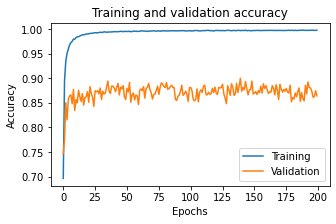

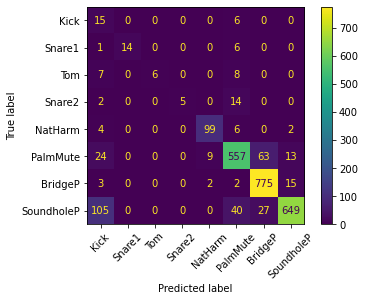

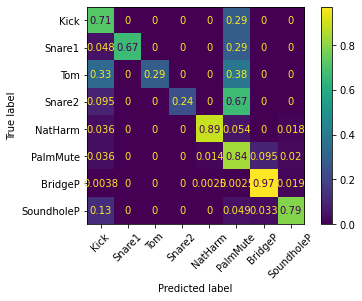

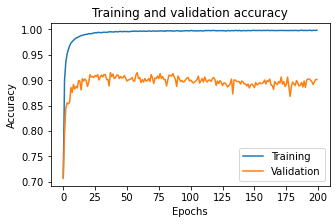

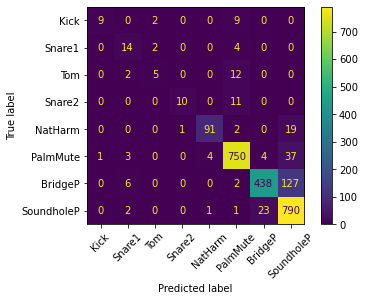

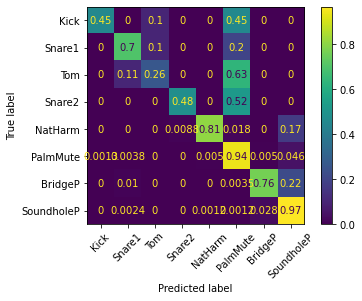

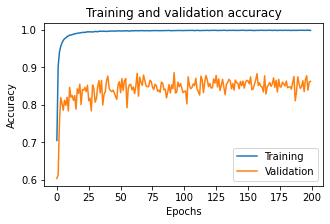

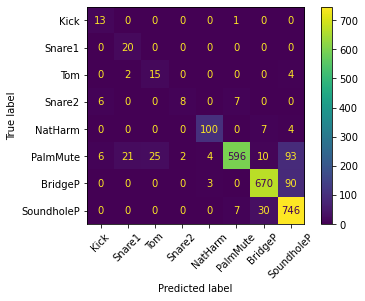

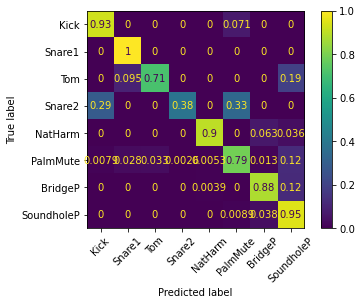

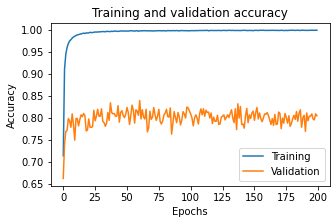

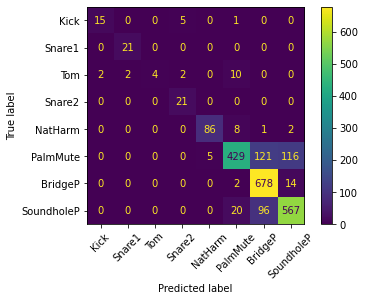

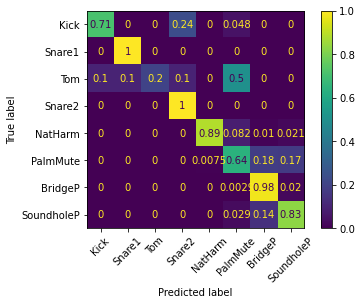

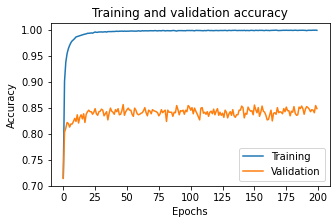

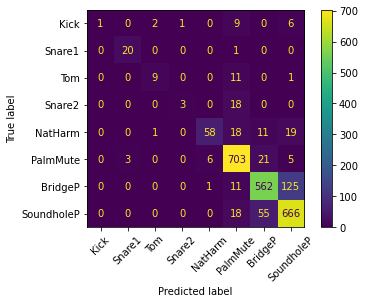

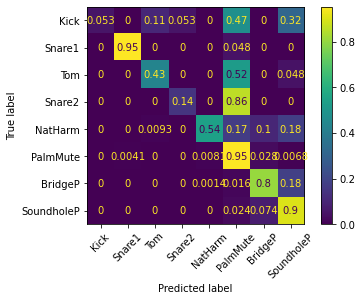

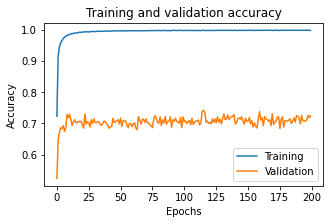

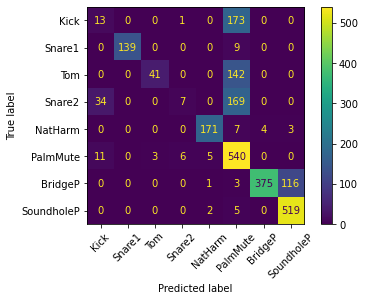

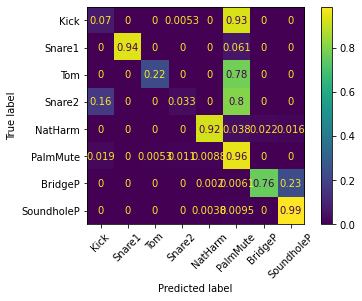

In [51]:
'''Call the main routine for each fold'''
result_model = []
train_aug_indexes = {}
X,y = dataset_features.to_numpy(), dataset_labels.to_numpy()

if not TRAIN_ONLY_ON_FULL_DATASET:
    with tf.device('/gpu:0'):
        metric_names = ['accuracy','f1_weightedmacroavg','confusion_matrix','classification_report','printable_classification_report']
        evaluation_metrics, quantized_model_evaluation_metrics,fullquantized_model_evaluation_metrics = {k:[] for k in metric_names}, {k:[] for k in metric_names}, {k:[] for k in metric_names}
        

        if USE_CROSS_VALIDATION:
            for foldidx,split_folds in enumerate(cv.split(X, y)): 
                if CUSTOM_PLAYER_K_FOLD:
                    train_idx, test_idx, val_idx  = split_folds
                else:
                    train_idx, test_idx = split_folds
                    val_idx = None

                train_aug_idx = []  # Indexes of the augmented data that correspond to the current training split
                if USE_AUGMENTED_DATA: # Here we want to select the augmented data that corresponds to the current training split
                    print('Selecting augmented data for fold',foldidx,'...')
                    training_metadata = metadata.iloc[train_idx]
                    training_sources_and_times = {tuple(k):True for k in training_metadata[['meta_audiofilePath','meta_onsetGroundTruthLabelTime']].values}
                    
                    for idx,source_aug,time_aug in  metadata_aug[['meta_augmentation_source','meta_onsetGroundTruthLabelTime']].itertuples():
                        if((source_aug,time_aug) in training_sources_and_times.keys()):
                            train_aug_idx.append(idx)
                    assert len(train_aug_idx) > 0, "No augmented data found for the current training split"
                    print('Found',len(train_aug_idx),'augmented samples for fold',foldidx)
                train_aug_indexes[foldidx] = train_aug_idx
                result_model.append(main_routine(X, y,
                                                train_idx = train_idx,
                                                test_idx  = test_idx,
                                                val_idx   = val_idx,
                                                aug_data = None if not USE_AUGMENTED_DATA else (metadata_aug, features_aug, labels_aug, train_aug_idx),
                                                foldcount = foldidx+1,
                                                is_k_fold = USE_CROSS_VALIDATION,
                                                eval_metrics           = evaluation_metrics,
                                                quantized_eval_metrics = quantized_model_evaluation_metrics,
                                                fullquantized_eval_metrics = fullquantized_model_evaluation_metrics))        
        else:
            raise NotImplementedError('Single training run setup is way behind the updates in the k-fold cross validation code.')
            # result_model = main_routine(X, y,
            #                             eval_metrics           = evaluation_metrics,
            #                             quantized_eval_metrics = quantized_model_evaluation_metrics,
            #                             fullquantized_eval_metrics = fullquantized_model_evaluation_metrics,
            #                             _val_split_size        = VAL_SPLIT_SIZE)

# Cross Validation average results

## Utilities for reports and metrics

In [52]:
def report_average(reports):
    mean_dict = dict()
    for label in reports[0].keys():
        dictionary = dict()

        if label in 'accuracy':
            mean_dict[label] = sum(d[label] for d in reports) / len(reports)
            continue

        for key in reports[0][label].keys():
            dictionary[key] = sum(d[label][key] for d in reports) / len(reports)
        mean_dict[label] = dictionary

    return mean_dict

def classification_report_dict2print(report):
    ret = ""
    classes = list(report.keys())[0:-3]
    summary_metrics = list(report.keys())[-3:]
    longest_1st_column_name = max([len(key) for key in report.keys()])
    ret = ' ' * longest_1st_column_name
    ret += '  precision    recall  f1-score   support\n\n'

    METRIC_DECIMAL_DIGITS = 4
    metric_digits = METRIC_DECIMAL_DIGITS + 2 # add 0 and dot

    header_spacing = 1
    metrics = list(report[classes[0]].keys())
    longest_1st_row_name = max([len(key) for key in report[classes[0]].keys()]) + header_spacing

    for classname in classes:
        ret += (' '*(longest_1st_column_name-len(classname))) + classname + ' '
        for metric in metrics:
            if metric != "support":
                ret += (' '*(longest_1st_row_name-metric_digits))
                ret += "%.4f" % round(report[classname][metric],METRIC_DECIMAL_DIGITS)
            else:
                current_support_digits = len(str(int(report[classname][metric])))
                ret += (' '*(longest_1st_row_name-current_support_digits))
                ret += "%d" % round(report[classname][metric],0)
        ret += '\n'
    ret += '\n'

    # Accuracy
    ret += (' '*(longest_1st_column_name-len(summary_metrics[0]))) + summary_metrics[0] + ' '
    ret += 2* (' '*longest_1st_row_name)
    ret += (' '*(longest_1st_row_name-metric_digits))
    ret += "%.4f" % round(report["accuracy"],METRIC_DECIMAL_DIGITS)
    current_support_digits = len(str(int(report[summary_metrics[-1]]['support'])))
    ret += (' '*(longest_1st_row_name-current_support_digits))
    ret += "%d" % round(report[summary_metrics[-1]]['support'],0)
    ret += '\n'
  
  
    for classname in summary_metrics[1:]:
        ret += (' '*(longest_1st_column_name-len(classname))) + classname + ' '
        for metric in metrics:
            if metric != "support":
                ret += (' '*(longest_1st_row_name-metric_digits))
                ret += "%.4f" % round(report[classname][metric],METRIC_DECIMAL_DIGITS)
            else:
                current_support_digits = len(str(int(report[classname][metric])))
                ret += (' '*(longest_1st_row_name-current_support_digits))
                ret += "%d" % round(report[classname][metric],0)
        ret += '\n'
    ret += '\n'

    return ret

## Compute average

In [53]:
if not TRAIN_ONLY_ON_FULL_DATASET:
    if USE_CROSS_VALIDATION:
        assert len(evaluation_metrics['accuracy']) == K_SPLITS, "The number of accuracy values does not match the number of folds ({} != {})".format(len(evaluation_metrics['accuracy']),K_SPLITS)
        
        averaged_classification_reports = report_average(evaluation_metrics["classification_report"])
        macro_avg_f1_score = averaged_classification_reports["macro avg"]["f1-score"]
        average_fold_accuracy = averaged_classification_reports["accuracy"]
        printable_avg_report = classification_report_dict2print(averaged_classification_reports)
        qm_printable_avg_report = "Not performed"
        if DO_TEST_QUANTIZATION:
            qm_avg_report = report_average(quantized_model_evaluation_metrics["classification_report"])
            qm_printable_avg_report = classification_report_dict2print(qm_avg_report)
            fullqm_avg_report = report_average(fullquantized_model_evaluation_metrics["classification_report"])
            fullqm_printable_avg_report = classification_report_dict2print(fullqm_avg_report)
        metrics_to_save = {'macro_avg_f1score' : macro_avg_f1_score,\
                        'average_fold_accuracy' : average_fold_accuracy,\
                        'DICTavg_classification_report' : averaged_classification_reports,\
                        'avg_classification_report' : printable_avg_report,\
                        'DICTavg_classification_report_for_quantized_model' : qm_avg_report,\
                        'avg_classification_report_for_quantized_model' : qm_printable_avg_report,\
                        'DICTavg_classification_report_for_fullquantized_model' : fullqm_avg_report,\
                        'avg_classification_report_for_fullquantized_model' : fullqm_printable_avg_report}
    else:
        assert len(evaluation_metrics['accuracy']) == 1
        metrics_to_save = {}
        for metric in evaluation_metrics.keys():
            metrics_to_save[metric] = evaluation_metrics[metric][0]
        for metric in quantized_model_evaluation_metrics.keys():
            metrics_to_save['quantizedmod_'+str(metric)] = quantized_model_evaluation_metrics[metric][0]


# Save Model Info

In [54]:
if not TRAIN_ONLY_ON_FULL_DATASET:
    if SAVE_MODEL_INFO:
        current_dir = MODELFOLDER + "/" + RUN_NAME
        # %mkdir -p "$current_dir"
        os.makedirs(current_dir,exist_ok = True)

        save_model_info(result_model[0] if type(result_model) == list else result_model,
                        optimizer,
                        USE_CROSS_VALIDATION,K_SPLITS,
                        metrics_to_save,
                        current_dir)
    else:
        print("RESULTS\n\n" + metrics_to_save)

# Train final model on the entire dataset

In [55]:
run_dir = os.path.join(MODELFOLDER,RUN_NAME)
assert os.path.exists(run_dir)

In [56]:
if TRAIN_ONLY_ON_FULL_DATASET:
    TRAIN_FINAL_MODEL = True

if TRAIN_FINAL_MODEL:
    use_early_stopping = False

    X_finmod,y_finmod = np.copy(X),np.copy(y)

    if USE_AUGMENTED_DATA:
        X_aug,y_aug = features_aug.to_numpy(), labels_aug.to_numpy()
        assert np.shape(X)[1] == np.shape(X_aug)[1], "The number of features in the augmented data does not match the number of features in the original data"
        print('Using augmented data to TRAIN THE FINAL MODEL')
        X_finmod = np.concatenate((X_finmod,X_aug),axis=0)
        y_finmod = np.concatenate((y_finmod,y_aug),axis=0)
        assert len(X_finmod) > len(X), "The number of samples in the augmented data is not greater than the number of samples in the original data"
        assert len(X_finmod) == len(y_finmod), "The number of samples in the augmented data does not match the number of labels in the original data"
        assert np.shape(X_finmod)[1] == np.shape(X_aug)[1], "The number of features in the augmented data does not match the number of features in the original data"

    ### DEFINE MODEL
    final_model = define_model_architecture(len(CLASSES),_verbose = True)
    loss_fn = get_loss()

    ### Normalize data if needed
    if DO_NORMALIZE_DATA:
        scaler = SCALER_TO_USE
        X_finmod = scaler.fit_transform(X_finmod)

        # Save final scaler and parameters
        with open(os.path.join(run_dir,'scaler.pickle'),'wb') as sf:
            pickle.dump(scaler,sf)
        with open(os.path.join(run_dir,'info.txt'),'a') as infof:
            if type(SCALER_TO_USE) == MinMaxScaler:
                infof.write("The scaler used was sklearn.preprocessing MinMaxScaler\nScaler parameters:\n")

                infof.write('MinMaxScaler().data_min_: '        + str(SCALER_TO_USE.data_min_)+'\n')
                infof.write('MinMaxScaler().data_max_: '        + str(SCALER_TO_USE.data_max_)+'\n')
                infof.write('MinMaxScaler().data_range_: '      + str(SCALER_TO_USE.data_range_)+'\n')
                infof.write('MinMaxScaler().scale_: '           + str(SCALER_TO_USE.scale_)+'\n')
                infof.write('MinMaxScaler().n_samples_seen_: '  + str(SCALER_TO_USE.n_samples_seen_)+'\n')
            elif type(SCALER_TO_USE) == StandardScaler:
                infof.write("The scaler used was sklearn.preprocessing StandardScaler\nScaler parameters:\n")
                infof.write('StandardScaler().mean_: '          + str(SCALER_TO_USE.mean_)+'\n')
                infof.write('StandardScaler().var_: '           + str(SCALER_TO_USE.var_)+'\n')
                infof.write('StandardScaler().scale_: '         + str(SCALER_TO_USE.scale_)+'\n')
                infof.write('StandardScaler().n_samples_seen_: '+ str(SCALER_TO_USE.n_samples_seen_)+'\n')
            else:
                raise Exception("\"%s\" scaler not supported"%(SCALER_TO_USE))

    ### PREPARE DATA IN CASE OF A FIRST CONV LAYER IN THE NET (1D or 2D)
    if type(final_model.layers[0]) == tf.keras.layers.Conv1D and not WINDOWED_INPUT_MODE == WindowedInputMode._2D:
        X_all = dataTo1DConv(X_finmod)
    elif WINDOWED_INPUT_MODE == WindowedInputMode._2D:
        X_all = dataTo2DConv(X_finmod)
    else:
        X_all = X_finmod

    ### COMPILE MODEL
    compile_model(final_model,optimizer,loss_fn,_verbose = True)

    ### SETUP TENSORBOARD
    tensorboard_callback = start_tensorboard(tb_dir,None)
    callbacks=[tensorboard_callback,]

    ### SETUP EARLY STOPPING (only if not in K-fold mode)
    if use_early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=200))

    # * FIT MODEL *
    final_model.fit(X_all, y, epochs=args['epochs'],
                    callbacks=callbacks,
                    batch_size=args['batchsize'])

In [57]:
if TRAIN_FINAL_MODEL:
    final_model_dir = MODELFOLDER + "/" + RUN_NAME + "/finalModel"
    # %mkdir -p "$final_model_dir"
    os.makedirs(final_model_dir,exist_ok = True)

    final_model.save(final_model_dir)

    # Convert and save lite model (Non quantized)
    convert2tflite(final_model_dir,model_name='final_model',quantization=None)
    # Convert and save lite model (Dynamically quantized)
    convert2tflite(final_model_dir,model_name='final_model_dynquant',quantization="dynamic")

# Save the model for TF Lite
## *(Only if not a Cross Validated run)*

In [58]:
# if USE_CROSS_VALIDATION is False:
#     model_path = MODELFOLDER + "/" + RUN_NAME
#     convert2tflite(model_path)                                                # standard TFLITE model
#     convert2tflite(model_path,model_name="model_partially_quantized",quantization="dynamic")   # Partial quantization  https://www.tensorflow.org/lite/performance/post_training_quantization#dynamic_range_quantization
    
#     quantization_dataset = X
#     if type(result_model.layers[0]) == tf.keras.layers.Conv1D:
#         quantization_dataset = np.expand_dims(X,axis = 2) # Adapt data for Conv1d
    
#     convert2tflite(model_path,model_name="model_float_fallback",quantization="float-fallback",dataset=quantization_dataset) # https://www.tensorflow.org/lite/performance/post_training_integer_quant#convert_using_float_fallback_quantization
#     convert2tflite(model_path,model_name="model_fully_quantized",quantization="full",dataset=quantization_dataset)          # FULL uint8 quantization https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization

In [59]:
# first_layer_is_conv = (type(result_model.layers[0]) == tf.keras.layers.Conv1D)

In [60]:
# TEST_SAVED_MODEL = None
# # TEST_SAVED_MODEL = 'model.tflite'
# # TEST_SAVED_MODEL = 'model_partially_quantized.tflite'
# # TEST_SAVED_MODEL = 'model_float_fallback.tflite'
# # TEST_SAVED_MODEL = 'model_fully_quantized.tflite'
# # TEST_SAVED_MODEL = 'quant_aware_model.tflite'
# # TEST_SAVED_MODEL = 'saved_model.pb'
# verbose_test = False

# def test_generic_model(model_filename,model_path,X_test,Y_test,first_layer_is_conv,verbose_test = False):
#     if model_filename.split('.')[-1] == 'tflite':
#         y_pred = test_tflite_model(model_path+'/'+model_filename,X_test,y_test,first_layer_is_conv,verbose_test = verbose_test)
#         correct = np.count_nonzero((np.array(y_pred) == np.ravel(y_test)).astype(int))
#         total = np.shape(y_test)[0]
#         accuracy = round(correct/total,4)
#     elif model_filename.split('.')[-1] == 'pb':
#         accuracy = test_regulartf_model(model_path,X_test,y_test,first_layer_is_conv,verbose_test = verbose_test)
#     else:
#         raise ValueError("")

#     return accuracy

# if USE_CROSS_VALIDATION is False and TEST_SAVED_MODEL is not None:
#     assert np.max([len(ev_metric) for ev_metric in evaluation_metrics]) == K_SPLITS

#     target_accuracy = evaluation_metrics['accuracy'][0]
#     accuracy = test_generic_model(TEST_SAVED_MODEL,model_path,X_test,Y_test,first_layer_is_conv)

#     epsilon = 1e-4
#     EQUAL_ACCURACY = abs(target_accuracy - accuracy) < epsilon

#     print("accuracy: " + str(accuracy))

#     if EQUAL_ACCURACY:
#         print("Accuracy of the original model and the saved TF model correspond(on same test set)")
#     else:
#         raise ValueError('Accuracy does not match target (Target: '+str(target_accuracy)+' but got '+str(accuracy)+' instead)')
# else:
#     print("TF model testing is disabled")

# Quantization aware fine-tuning

In [61]:
# #################################################
# PERFORM_QUANZATION_AWARE_TRAINING = False       #
# #################################################
# if PERFORM_QUANZATION_AWARE_TRAINING:
#     pip_install('tensorflow_model_optimization')

In [62]:
# if PERFORM_QUANZATION_AWARE_TRAINING:
#     imported_model = tf.keras.models.load_model(model_path)

#     import tensorflow_model_optimization as tfmot

#     quantize_model = tfmot.quantization.keras.quantize_model

#     # q_aware stands for for quantization aware.
#     q_aware_model = None
#     q_aware_model = quantize_model(imported_model)

#     # `quantize_model` requires a recompile.
#     _,loss_fn = define_model_architecture(len(CLASSES),_verbose = True)  # Get only the loss function
#     compile_model(q_aware_model,optimizer,loss_fn,_verbose = True)  # Recompile the quantization aware model

#     q_aware_model.summary()

In [63]:
# if PERFORM_QUANZATION_AWARE_TRAINING:
#     tb_dir = "logs2/fit/"
#     %tensorboard --logdir $tb_dir

In [64]:
# if PERFORM_QUANZATION_AWARE_TRAINING:
#     finetuning_epochs = 50
#     tensorboard_callback = start_tensorboard(tb_dir,None)

#     q_history = q_aware_model.fit(X_train, y_train, epochs=finetuning_epochs, validation_data = (X_valid,y_valid),
#                                 callbacks=[tensorboard_callback],
#                                 batch_size=args['batchsize'])

In [65]:
# if PERFORM_QUANZATION_AWARE_TRAINING:
#     quant_model_path = MODELFOLDER + "/" + RUN_NAME + "/quant_aware_model.tflite"

#     converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
#     converter.optimizations = [tf.lite.Optimize.DEFAULT]

#     quantized_tflite_model = converter.convert()

#     with tf.io.gfile.GFile(quant_model_path, 'wb') as f:
#         f.write(quantized_tflite_model)

## Rename current output folder by prefixing the accuracy value

In [66]:
if not TRAIN_ONLY_ON_FULL_DATASET:
    # Make window folder
    window_folder = os.path.join(os.path.dirname(run_dir),FEATURE_WINDOW_SIZE.name)
    if not os.path.exists(window_folder):
        os.mkdir(window_folder)
    problem_folder = os.path.join(window_folder,classification_task.value[1])
    if not os.path.exists(problem_folder):
        os.mkdir(problem_folder)
    # Rename folder
    if os.path.exists(os.path.join(run_dir,'info.txt')):
        metrics_prefix = 'c_' if 'CrossValidated' in os.path.basename(run_dir) else ''

        metrics_prefix += 'maf1_%.4f_acc_%.4f_'%(round(metrics_to_save['macro_avg_f1score'],4),round(metrics_to_save['average_fold_accuracy'],4))
    
        window_prefix = FEATURE_WINDOW_SIZE.name

        problem_prefix = classification_task.value[1]+'_'
            
        newfoldername = os.path.join(problem_folder,window_prefix+problem_prefix+metrics_prefix+os.path.basename(run_dir))
        # print('Renaming "'+run_dir+'" to "'+newfoldername+'"')
        os.rename(run_dir,newfoldername)
        run_dir = newfoldername
    else:
        errfoldername = os.path.join(os.path.dirname(run_dir),'ERR_'+os.path.basename(run_dir))
        os.rename(run_dir,errfoldername)
        run_dir = errfoldername

## Testing with extra test data
This data was extracted from extra recordings, made to test the system in a real life scenario.  
Here we test only to veryfy that everything is working here, before making a shift to the real life test

In [67]:
TEST_WITH_EXTRA_DATA = False

In [68]:
if TRAIN_FINAL_MODEL and TEST_WITH_EXTRA_DATA:
    """ Load the test data """

    TEST_DATA_FILE_PATH = os.path.join(DATAFOLDER,'20221011_110715_test_onlycorrectdetections.pickle')
    print("Loading test data from pickle...")
    with open(TEST_DATA_FILE_PATH,'rb') as pf:
        testdataset = pickle.load(pf)
    testdataset.sort_values(['meta_expressive_technique_id','meta_audiofilePath'],inplace = True)
    print('Done.')
    # If this fails, the dataset has changed from the last time the program was run successfully (CHECK THE DATA!!!)
    assert testdataset.shape == (754,507)
    # display(testdataset)


    """ Drop unused features (like the train/test dataset) """

    drop_unused_features(testdataset,inplace=True)
    assert testdataset.shape == (754,504)


    """ Divide the test data into metadata, features and labels (like the train/test dataset) """

    test_metadata, test_features, test_labels = divide_dataset(testdataset)
    assert test_metadata.shape[0] == test_features.shape[0] == test_labels.shape[0] == 754
    assert test_metadata.shape[1] == 9
    assert test_features.shape[1] == 495

    """ Filter the dataset according to the task """
    # This might mean removing samples or renaming classes
    test_features,test_labels,test_metadata = filter_dataset(test_features.copy(),test_labels.copy(),test_metadata.copy(),classification_task)



    """ Apply the feature selection computed for the train/test set (like the train/test dataset) """

    test_features = test_features.copy().loc[:,selected_features]

    if len(selected_features) != AUTO_FEATURE_NUMBER:
        raise Exception('The number of selected_features ('+str(len(selected_features))+') is not the same as AUTO_FEATURE_NUMBER ('+str(AUTO_FEATURE_NUMBER)+'). Check the code.')

    if test_features.shape[1] != AUTO_FEATURE_NUMBER:
        raise Exception('The number of features in the test dataset ('+str(test_features.shape[1])+') is different from the number of features in the train/test dataset ('+str(AUTO_FEATURE_NUMBER)+')')

In [69]:
if TRAIN_FINAL_MODEL and TEST_WITH_EXTRA_DATA:
    extra_test_x = test_features.to_numpy()
    extra_test_y = test_labels.to_numpy()

    

    if DO_NORMALIZE_DATA:
        # This scaler was "learned" a few cells above on the whole train/test dataset (obviously exluding the etra-test data)
        extra_test_x = scaler.transform(extra_test_x)

    if type(final_model.layers[0]) == tf.keras.layers.Conv1D:
        extra_test_x = np.expand_dims(extra_test_x,axis = 2) # Adapt data for Conv1d ([batch_shape, steps, input_dim] -> in our case indim = 1, steps = features, batchshape = train datset size)

    y_true = np.squeeze(extra_test_y)
    y_pred = np.argmax(final_model(extra_test_x),axis=1)
    cm_acc, f1mw, cm_conf_matrix, cm_classf_report, cm_printable_classf_report = compute_metrics(y_true, y_pred, _verbose=False)

    with open(os.path.join(run_dir,'info.txt'),'a') as infof:
        infof.write('______________________________________________________________________________________________________________________________________________________\n\n\n')
        infof.write('+----------------------------------------------------------------+\n')
        infof.write('| Results obtained on extra test recordings with the FINAL MODEL |\n')
        infof.write('+----------------------------------------------------------------+\n\n')
        infof.write('Extra-test-Accuracy: '+str(cm_acc)+'\n\n')
        infof.write('Extra-test-F1 Score (weighted average): '+str(f1mw)+'\n\n')
        infof.write('Extra-test-ConfusionMatrix: \n'+str(cm_conf_matrix)+'\n\n')
        infof.write('Extra-test-Report: \n'+str(cm_printable_classf_report)+'\n\n')

In [70]:
print('*--* Training successfully completed. *--*')
print("Data at",run_dir)

*--* Training successfully completed. *--*
Data at ./output/_4800windowed/full/_4800windowedfull_c_maf1_0.6904_acc_0.8342_CrossValidatedRun_20230227-141611


In [71]:
import requests

def send_to_telegram(message):
    apiToken = 'apiKeyHere'
    chatID = 'chatIDHere'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        # print(response.text)
    except Exception as e:
        print(e)

# send_to_telegram('Training completed in folder ' + run_dir)


# check if 'best_notified_accyracy_yet.txt' exists
# if it does, read the value, compare to the current and notify via telegram if the current is better
# if it doesn't, create it and write the current value

def save_and_notify_if_greater(newvalue, metricfilepath, metric_name, problem_name,window_name):
    BA_FILE = metricfilepath
    if os.path.exists(BA_FILE):
        print('Reading best notified '+metric_name+' from file '+BA_FILE)
        with open(BA_FILE) as f:
            best_notified_metric_yet = float(f.readline())
    else:
        print('No best notified '+metric_name+' file found. Creating new one.')
        best_notified_metric_yet = 0.0

    if newvalue > best_notified_metric_yet:
        print('New best '+metric_name+' found: '+str(newvalue)+ ' (old best: '+str(best_notified_metric_yet)+')')
        message = str(newvalue) + '\nfrom run in folder ' + run_dir
        with open(BA_FILE,'w') as f:
            f.write(message)
        # send_to_telegram('New best %s: %.2f%%\nfrom run in folder %s'%(metric_name,round(newvalue,4)*100,run_dir))
        send_to_telegram('FOR PROBLEM: %s\nWITH WINDOW:%s\nNew best %s: %.2f%%'%(problem_name,window_name,metric_name,round(newvalue,4)*100))
    return newvalue if newvalue > best_notified_metric_yet else best_notified_metric_yet

if not TRAIN_ONLY_ON_FULL_DATASET:
    best_afa = save_and_notify_if_greater(metrics_to_save['average_fold_accuracy'], os.path.join(problem_folder,FEATURE_WINDOW_SIZE.name+'best_accuracy_yet_notified.txt'), 'Accuracy',classification_task.value[1],FEATURE_WINDOW_SIZE.name)
    best_maf1 = save_and_notify_if_greater(metrics_to_save['macro_avg_f1score'], os.path.join(problem_folder,FEATURE_WINDOW_SIZE.name+'best_maf1_yet_notified.txt'), 'Macro Average F1-Score',classification_task.value[1],FEATURE_WINDOW_SIZE.name)

No best notified Accuracy file found. Creating new one.
New best Accuracy found: 0.8341665380887976 (old best: 0.0)
No best notified Macro Average F1-Score file found. Creating new one.
New best Macro Average F1-Score found: 0.6904238500549784 (old best: 0.0)


### Write results to file
to quickly preview them without scrolling

In [72]:
if not TRAIN_ONLY_ON_FULL_DATASET:
    last_metrics_filepath = './last_metrics.txt'

    prev_avg_acc = 0.0
    prev_mavg_f1 = 0.0
    if os.path.exists(last_metrics_filepath):
        with open(last_metrics_filepath,'r') as f:
            lines = f.readlines()
            if len(lines) > 0 and lines[0].strip() != '':
                prev_avg_acc = float(re.findall('\d\d\.\d\d%',lines[2])[0].rstrip('%'))
                prev_mavg_f1 = float(re.findall('\d\d\.\d\d%',lines[3])[0].rstrip('%'))

    afa =  round(metrics_to_save['average_fold_accuracy']*100,2)
    maf1 = round(metrics_to_save['macro_avg_f1score']*100,2)
    if afa != prev_avg_acc or maf1 != prev_mavg_f1:
        with open(last_metrics_filepath,'w') as f:
            print('| Time:  '+strftime("%H:%M - %Y/%m/%d")+'                |', file = f)
            print('|                  last  |  prev  |   best |', file = f)
            print('| Avg. Accuracy:  %.2f%% | %.2f%% | %.2f%% |'%(afa,prev_avg_acc,round(best_afa*100,2)), file = f)
            print('| MAvg. F1Score:  %.2f%% | %.2f%% | %.2f%% |'%(maf1,prev_mavg_f1,round(best_maf1*100,2)), file = f)